In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from astropy.cosmology import Planck18 as cosmo
from scipy import integrate
from scipy.integrate import quad
from scipy.special import gamma
from scipy.interpolate import interp1d
from scipy.integrate import simpson

import astropy.units as u
import bz2


%config InlineBackend.figure_format ='retina'
plt.rcParams["text.usetex"] = True

# Merger Rates

Total Intrinsic Events for HS-nod-SN-high-accr.dat.bz2: 9406.903182097385
Total Intrinsic Events for HSnodB20noSN_extrapolated.dat.bz2: 39363.80689342792
Total Intrinsic Events for HSnodB20SN_extrapolated.dat.bz2: 36789.693230919744
Total Intrinsic Events for popIII_K16_extrapolated.dat.bz2: 1410.0304047830805
Total Intrinsic Events for Q3nod_K16_extrapolated.dat.bz2: 657.2212240367769
Total Intrinsic Events for Q3d_K16_extrapolated.dat.bz2: 73.5230628710847


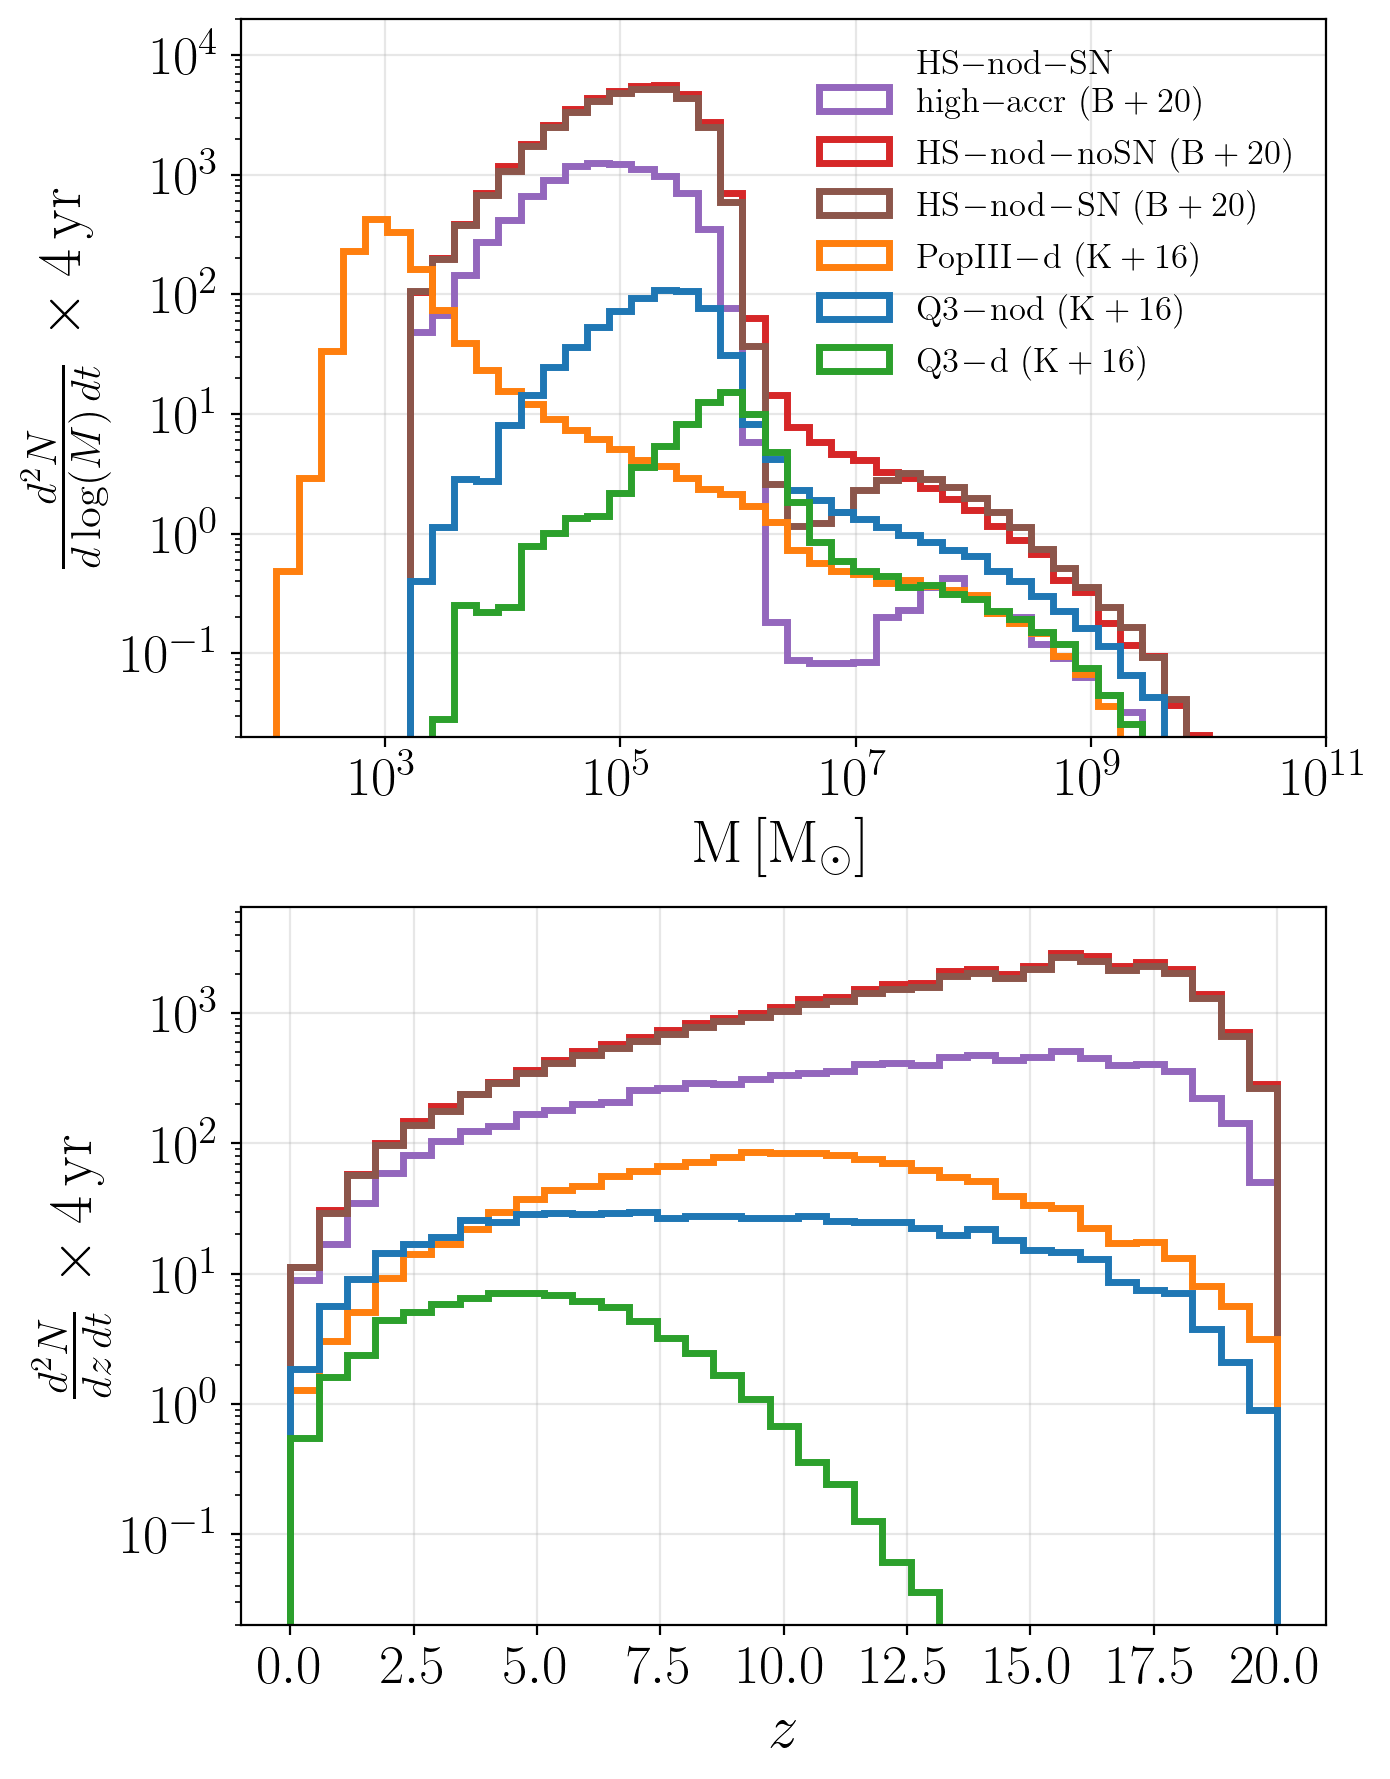

In [49]:
# Merger rates para las 6 simulaciones al mismo tiempo

file_paths = [
    ("HS-nod-SN-high-accr.dat.bz2",       r'$\shortstack[l]{$\mathrm{HS{-}nod{-}SN}$\\$ \mathrm{high{-}accr\ (B+20)}$}$', "tab:purple"),
    ("HSnodB20noSN_extrapolated.dat.bz2", r'$\mathrm{HS\!-\!nod\!-\!noSN\ (B+20)}$', "tab:red"), 
    ("HSnodB20SN_extrapolated.dat.bz2",   r'$\mathrm{HS\!-\!nod\!-\!SN\ (B+20)}$', "tab:brown"),  
    ("popIII_K16_extrapolated.dat.bz2",   r'$\mathrm{PopIII\!-\!d\ (K+16)}$', "tab:orange"),
    ("Q3nod_K16_extrapolated.dat.bz2",    r'$\mathrm{Q3\!-\!nod\ (K+16)}$', "tab:blue"),
    ("Q3d_K16_extrapolated.dat.bz2",      r'$\mathrm{Q3\!-\!d\ (K+16)}$', "tab:green")
]


column_names = [
    "z_merger", "m1", "m2", "a1", "a2", "alpha", "beta", "gamma", "psi",
    "afin", "mfin", "vkick", "vesc_halo", "vesc_bar", "Mcluster", "Mdisk_stars",
    "Mdisk_gas", "Mbulge_stars", "Mbulge_gas", "MNSC", "Mreservoir",
    "Mhalo_final", "halo_density"
]

c = 9.72e-15  # Velocidad de la luz en Mpc/s

z_bins = np.linspace(0, 20, 36)
mass_bins = np.logspace(1.7, 10, 45)

fig, axs = plt.subplots(2, 1, figsize=(7,9), sharex=False)

for path, label, color in file_paths:
    with bz2.open(path, "rt") as f:
        df = pd.read_csv(f, sep='\s+', names=column_names)

    if df["a1"].min() >= 0 and df["a2"].min() >= 0:
        df["a1"] = df["a1"] * np.sign(np.cos(df["beta"]))
        df["a2"] = df["a2"] * np.sign(np.cos(df["gamma"]))

    df["Dl_s"] = cosmo.luminosity_distance(df["z_merger"]).value
    df["d2N_dzdt"] = (4 * np.pi * c * df["halo_density"] * df["Dl_s"]**2 / ((1 + df["z_merger"])**2))

    with bz2.open(path, "wt") as f:
        df.to_csv(f, sep="\t", index=False, header=False)

    df["total_mass"] = df["m1"] + df["m2"]
    df["z_merger_noisy"] = df["z_merger"] + np.random.normal(0, 0.55, len(df))
    
    mass_hist, mass_edges = np.histogram(df["total_mass"], bins=mass_bins, weights=df["d2N_dzdt"])
    z_hist, z_edges = np.histogram(df["z_merger_noisy"], bins=z_bins, weights=df["d2N_dzdt"])
    
    print(f"Total Intrinsic Events for {path}: {np.sum(mass_hist)*3600 * 24 * 365 * 4}")
    
    axs[0].hist(
        0.5 * (mass_edges[:-1] + mass_edges[1:]),
        bins=mass_bins,
        weights=mass_hist * 3600 * 24 * 365 * 4,
        histtype="step",
        color=color,
        label=label,
        linewidth=2.5
    )

    axs[1].hist(
        0.5 * (z_edges[:-1] + z_edges[1:]),
        bins=z_bins,
        weights=z_hist * 3600 * 24 * 365 * 4,
        histtype="step",
        color=color,
        label=label,
        linewidth=2.5
    )

axs[0].set_xscale("log")
axs[0].set_yscale("log")
axs[0].set_xlabel(r"$\mathrm{M} \, [\mathrm{M}_\odot]$", fontsize = 22)
axs[0].set_ylabel(r"$\frac{d^2N}{d\log(M) \, dt} \, \times 4 \, \mathrm{yr}$", fontsize = 22)
axs[0].grid(alpha=0.3)
axs[0].tick_params(labelsize=20)
axs[0].set_ylim(2e-2, 2e4)
axs[0].set_xlim(60, 1e11)
axs[0].legend(frameon=False, fontsize = 12.5, loc='upper right')

axs[1].set_yscale("log")
axs[1].set_xlabel(r"$z$", fontsize = 22)
axs[1].set_ylabel(r"$\frac{d^2N}{dz \, dt} \, \times 4 \, \mathrm{yr}$", fontsize = 22)
axs[1].grid(alpha=0.3)
axs[1].set_xticks(np.arange(0, 21, 2.5))
axs[1].tick_params(labelsize=20)
axs[1].set_ylim(2e-2, 6.5e3)
#axs[1].set_xlim(-1, 21)


plt.tight_layout()
#plt.savefig('SecondRun/Images/MergerRatesMz.pdf')
plt.show()

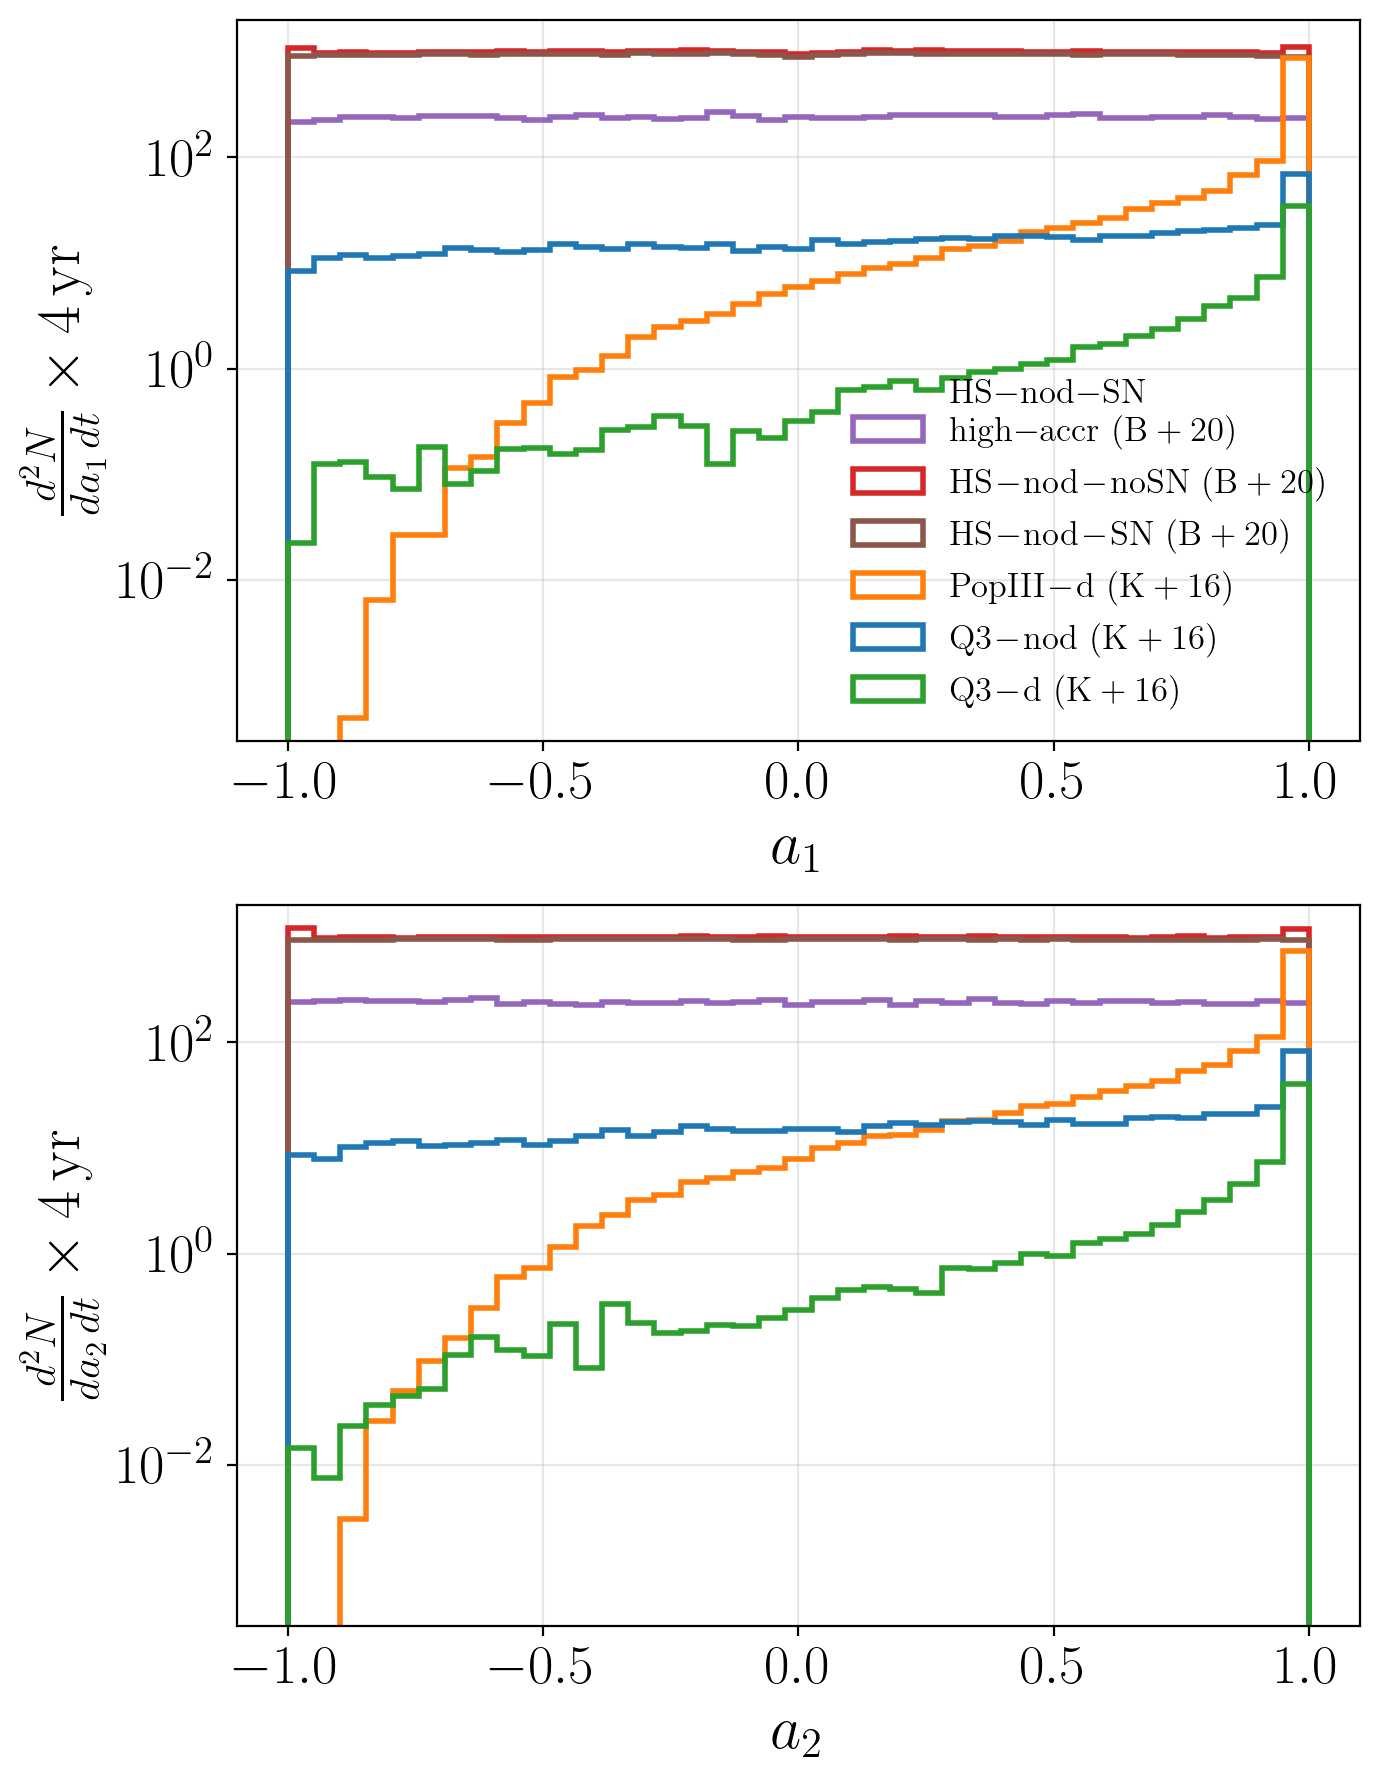

In [51]:
# Mismo merger rate que el anterior pero ahora vs a1 y a2

a_bins = np.linspace(-1, 1, 40)

fig, axs = plt.subplots(2, 1, figsize=(7,9), sharex=False)

column_names = [
    "z_merger", "m1", "m2", "a1", "a2", "alpha", "beta", "gamma", "psi",
    "afin", "mfin", "vkick", "vesc_halo", "vesc_bar", "Mcluster", "Mdisk_stars",
    "Mdisk_gas", "Mbulge_stars", "Mbulge_gas", "MNSC", "Mreservoir",
    "Mhalo_final", "halo_density", "Dl_s", "d2N_dzdt"
]

for path, label, color in file_paths:
    df = pd.read_csv(path, sep='\s+', names=column_names)

     
    a1_hist, a1_edges = np.histogram(df["a1"], bins=a_bins, weights=df["d2N_dzdt"])
    a2_hist, a2_edges = np.histogram(df["a2"], bins=a_bins, weights=df["d2N_dzdt"])


    axs[0].hist(
        0.5 * (a1_edges[:-1] + a1_edges[1:]),
        bins=a_bins,
        weights=a1_hist * 3600 * 24 * 365 * 4,
        histtype="step",
        color=color,
        label=label,
        linewidth=2
    )

    axs[1].hist(
        0.5 * (a2_edges[:-1] + a2_edges[1:]),
        bins=a_bins,
        weights=a2_hist * 3600 * 24 * 365 * 4,
        histtype="step",
        color=color,
        label=label,
        linewidth=2
    )
    
# ------ Graficar ------
#axs[0].set_xscale("log")
axs[0].set_yscale("log")
axs[0].set_xlabel(r"$a_1$", fontsize = 22)
axs[0].set_ylabel(r"$\frac{d^2N}{da_1 \, dt} \times 4 \, \mathrm{yr}$", fontsize = 22)
axs[0].grid(alpha=0.3)
axs[0].tick_params(labelsize=20)
axs[0].set_ylim(3e-4, 2e3)
axs[0].set_xlim(-1.1, 1.1)
axs[0].legend(frameon=False, fontsize = 12.5, loc = 'lower right')

axs[1].set_yscale("log")
axs[1].set_xlabel(r"$a_2$", fontsize = 22)
axs[1].set_ylabel(r"$\frac{d^2N}{da_2 \, dt} \times 4 \, \mathrm{yr}$", fontsize = 22)
axs[1].grid(alpha=0.3)
axs[1].set_ylim(3e-4, 2e3)
axs[1].tick_params(labelsize=20)
axs[1].set_xlim(-1.1,1.1)

plt.tight_layout()
plt.savefig('SecondRun/Images/MergerRatesa1a2.pdf')
plt.show()

# Detected Rates

In [2]:
# Esta celda agarra el catalogo de eventos generado y le incorpora los parametros simulados de posicion y orientacion, 
# haciendo que cada evento de repita N veces con el set de parametros 

sampled_events = pd.read_csv("SecondRun/HSnodSNhighaccr/HSnodSNhighaccr_redshifts.csv")
parametros = pd.read_csv("parametrosgeneradosN100.csv")

n_eventos = len(sampled_events)

sampled_events_expanded = pd.DataFrame(np.repeat(sampled_events.values, 100, axis=0), columns=sampled_events.columns)
parametros_expanded = pd.concat([parametros] * n_eventos, ignore_index=True)

final_catalog = pd.concat([sampled_events_expanded.reset_index(drop=True), parametros_expanded], axis=1)
    
final_catalog.to_csv("SecondRun/HSnodSNhighaccr/HSnodSNhighaccr_catalog1M.csv", index=False)

In [10]:
# cantidad de realizaciones por archivo
pop = 1410.03
q3 = 73.523
q3nod = 657.221 
hsno = 36789.693
hsnono = 39363.806
hsha = 9406.90


file_paths = [
    ("HS-nod-SN-high-accr_signed.dat.bz2", "HS nod SN high accr (B+20)", "tab:purple", "orchid"),
    ("HSnodB20noSN_extrapolated_signed.dat.bz2", "HS nod noSN (B+20)", "tab:red", "coral"), 
    ("HSnodB20SN_extrapolated_signed.dat.bz2", "HS nod SN (B+20)", "tab:brown", "chocolate"),  
    ("popIII/popIII_K16_extrapolated.dat.bz2", "Pop III d (K+16)", "tab:orange", "gold"),
    ("q3nod/q3nod_K16_extrapolated.dat.bz2", "Q3 nod (K+16)", "tab:blue", "deepskyblue"),
    ("q3d/q3d_K16_extrapolated.dat.bz2", "Q3 d (K+16)", "tab:green", "limegreen")
]

print(10000/pop)
print(10000/q3)
print(10000/q3nod)
print(10000/hsno)
print(10000/hsnono)
print(10000/hsha)

7.092047686928647
136.01186023421243
15.215581973187101
0.27181526086667807
0.25404047565928967
1.0630494636915455


In [55]:
#Esta celda filtra los eventos con SNR > 8 y los clasifica como detectables, luego calcula un average detectability para cada evento simulado, junto con la mediana y moda de los SNR.

df = pd.read_csv('SecondRun/HSnodSN/HSnodSN_SNRLISAbeta.csv')

df['Detectable'] = df['SNR_LISAbeta'] > 8.001

group_cols = ['m1', 'm2', 'a1', 'a2', 'z_merger']

group_stats = df.groupby(group_cols).agg({
    'Detectable': 'mean',
    'SNR_LISAbeta': ['mean', 'median']
}).reset_index()

group_stats.columns = group_cols + ['Average_Detectability', 'Mean_SNR', 'Median_SNR']

df = df.merge(group_stats, on=group_cols, how='left')

df.to_csv("SecondRun/HSnodSN/HSnodSN_SNRLb_AveDet.csv", index=False)

In [56]:
# Esto agarra el catalogo con los SNR ya calculados (y el average detectability para cada evento) y  elimina las columnas con los parametros de posicion y orientacion,
# recuperando la cantidad de eventos sampleados segun cuantos eventos suceden en 4 años.

file_path = "SecondRun/HSnodSN/HSnodSN_SNRLb_AveDet.csv"
df = pd.read_csv(file_path)

columns_to_drop = ['tc', 'RA', 'DEC', 'phi_c', 'iota', 'psi']

df_filtered = df.drop(columns=columns_to_drop)

df_unique = df_filtered.drop_duplicates(subset=['m1', 'm2', 'a1', 'a2'])

output_path = "SecondRun/HSnodSN/HSnodSN_SNRLb_final.csv"
df_unique.to_csv(output_path, index=False)

print(f"Dimensiones finales: {df_unique.shape}")
print(f"Dimensiones finales: {df_filtered.shape}")

Dimensiones finales: (10000, 26)
Dimensiones finales: (1000000, 26)


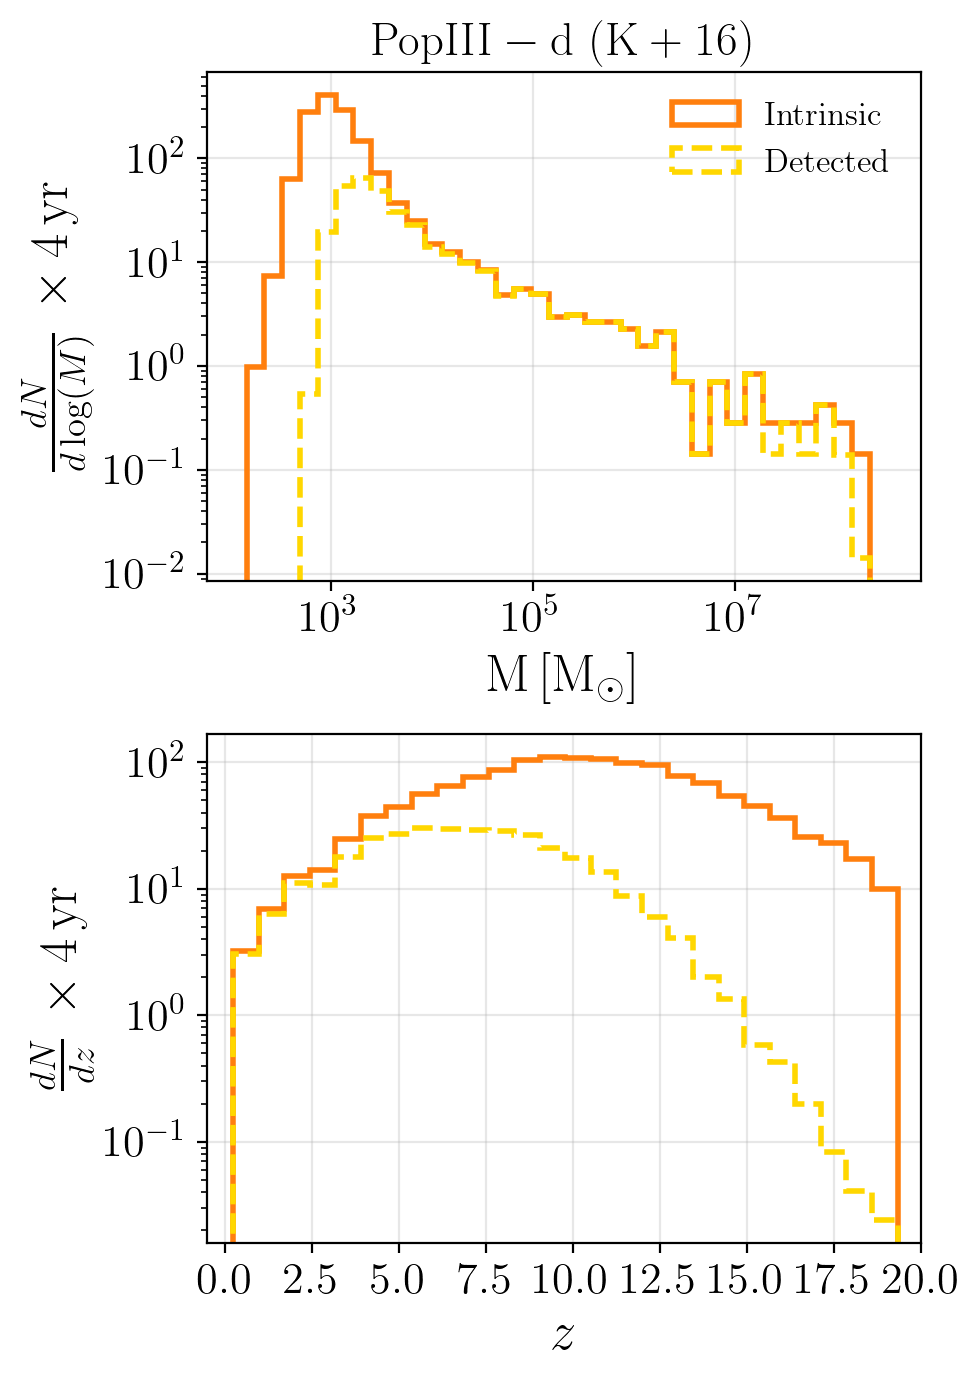

Total de eventos: 1410.03
Total de eventos detectables: 320.86642680000244


In [20]:
file_path = "SecondRun/PopIIId/popIII_SNRLb_final.csv"

n = 7.092047686928647

data = pd.read_csv(file_path)

# ------ Se ordenann los datos para crear los histogramas ---------
# Histograma de redshift
z_bins = np.linspace(data["z_merger"].min(), data["z_merger"].max(), 27)

# Histograma de masa total
data["total_mass"] = data["m1"] + data["m2"]
mass_bins = np.logspace(np.log10(data["total_mass"].min()), np.log10(data["total_mass"].max()), 40)
mass_hist, mass_edges = np.histogram(data["total_mass"], bins=mass_bins)
mass_hist1, mass_edges = np.histogram(data["total_mass"], bins=mass_bins, weights = data["Average_Detectability"])

#----- Aplicar gaussiana en z ------
sigma_z = 0.55 
data["z_merger_noisy"] = data["z_merger"] + np.random.normal(0, sigma_z, len(data))

z_hist, z_edges = np.histogram(data["z_merger_noisy"], bins=z_bins)
z_hist1, z_edges = np.histogram(data["z_merger_noisy"], bins=z_bins, weights = data["Average_Detectability"])

# ------ Graficar ------
fig, axs = plt.subplots(2, 1, figsize=(5, 7), sharex=False)

axs[0].hist(
    0.5 * (mass_edges[:-1] + mass_edges[1:]), 
    bins=mass_bins,
    weights=mass_hist /n,
    histtype='step',
    stacked=True,
    fill=False,
    color="tab:orange",
    label=r'$\mathrm{Intrinsic}$',
    linewidth=2
)
axs[0].hist(
    0.5 * (mass_edges[:-1] + mass_edges[1:]), 
    bins=mass_bins,
    weights=mass_hist1 /n,
    histtype='step',
    stacked=True,
    fill=False,
    color="gold",
    label=r'$\mathrm{Detected}$',
    linestyle='--',
    linewidth=2
)
axs[0].set_xscale("log")
axs[0].set_yscale("log")
axs[0].set_xlabel(r"$\mathrm{M} \, [\mathrm{M}_\odot]$", fontsize = 19)
axs[0].set_ylabel(r"$\frac{dN}{d\log(M)} \, \times 4 \, \mathrm{yr}$", fontsize = 19)
axs[0].grid(alpha=0.3)
axs[0].tick_params(labelsize=16)
#axs[0].set_ylim(2e-3, 2e4)
axs[0].set_xlim(60, 7e8)
axs[0].set_title(r'$\mathrm{PopIII-d\ (K+16)}$', fontsize = 17)
axs[0].legend(frameon=False, fontsize = 12)

axs[1].hist(
    0.5 * (z_edges[:-1] + z_edges[1:]),  
    bins=z_bins,
    weights=z_hist  /n,
    histtype='step',
    stacked=True,
    fill=False,
    color="tab:orange",
    label=r'$\mathrm{Intrinsic}$',
    linewidth=2
)
axs[1].hist(
    0.5 * (z_edges[:-1] + z_edges[1:]),  
    bins=z_bins,
    weights=z_hist1  /n,
    histtype='step',
    stacked=True,
    fill=False,
    color="gold",
    label=r'$\mathrm{Detected}$',
    linestyle='--',
    linewidth=2
)

axs[1].set_yscale("log")
axs[1].set_xlabel(r"$z$", fontsize = 19)
axs[1].set_ylabel(r"$\frac{dN}{dz} \, \times 4 \, \mathrm{yr}$" , fontsize = 19)
axs[1].tick_params(labelsize=16)
axs[1].set_xticks(np.arange(0, 21, 2.5))
axs[1].grid(alpha=0.3)
axs[1].set_xlim(-0.5, 20.0)
#axs[1].set_ylim(2e-3, 6.5e3)

plt.tight_layout()
plt.savefig("SecondRun/Images/popIII_detected.pdf", dpi=300)
plt.show()

print(f"Intrinsic Events: {np.sum(mass_hist)/n}" )
print(f"Detected Events: {np.sum(mass_hist1)/n}" )

In [2]:
# cantidad de eventos sumando todos los con Mean_SNR>8
files = [
    ("SecondRun/PopIIId/popIII_SNRLb_final.csv",7.092047686928647),
    ("SecondRun/Q3d/Q3d_SNRLb_final.csv",136.01186023421243),
    ("SecondRun/Q3nod/Q3nod_SNRLb_final.csv",15.215581973187101),
    ("SecondRun/HSnodnoSN/HSnodnoSN_SNRLb_final.csv",0.25404047565928967),
    ("SecondRun/HSnodSN/HSnodSN_SNRLb_final.csv",0.27181526086667807),
    ("SecondRun/HSnodSNhighaccr/HSnodSNhighaccr_SNRLb_final.csv",1.0630494636915455)
]

for f, n in files:
    df = pd.read_csv(f)
    count = (df["Mean_SNR"] > 8).sum() 
    print(f"{f}: {count/n} eventos con mean SNR > 8")

SecondRun/PopIIId/popIII_SNRLb_final.csv: 293.427243 eventos con mean SNR > 8
SecondRun/Q3d/Q3d_SNRLb_final.csv: 72.94216829999999 eventos con mean SNR > 8
SecondRun/Q3nod/Q3nod_SNRLb_final.csv: 652.8176193 eventos con mean SNR > 8
SecondRun/HSnodnoSN/HSnodnoSN_SNRLb_final.csv: 38793.030813 eventos con mean SNR > 8
SecondRun/HSnodSN/HSnodSN_SNRLb_final.csv: 36270.9583287 eventos con mean SNR > 8
SecondRun/HSnodSNhighaccr/HSnodSNhighaccr_SNRLb_final.csv: 9285.55099 eventos con mean SNR > 8


In [53]:
files = [
    ("SecondRun/PopIIId/popIII_SNRLb_final.csv",7.092047686928647),
    ("SecondRun/Q3d/Q3d_SNRLb_final.csv",136.01186023421243),
    ("SecondRun/Q3nod/Q3nod_SNRLb_final.csv",15.215581973187101),
    ("SecondRun/HSnodnoSN/HSnodnoSN_SNRLb_final.csv",0.25404047565928967),
    ("SecondRun/HSnodSN/HSnodSN_SNRLb_final.csv",0.27181526086667807),
    ("SecondRun/HSnodSNhighaccr/HSnodSNhighaccr_SNRLb_final.csv",1.0630494636915455)
]


for f, n in files:
    df = pd.read_csv(f)
    total = (df["Mean_SNR"] > 8).sum()
    count = ((df["Mean_SNR"] > 8) & (df["Mean_SNR"] < 100)).sum()
    porcentaje = (count / total) * 100
    print(f"{f}: {porcentaje:.2f}% de eventos con 8 < mean SNR < 100")

SecondRun/PopIIId/popIII_SNRLb_final.csv: 89.96% de eventos con 8 < mean SNR < 100
SecondRun/Q3d/Q3d_SNRLb_final.csv: 3.91% de eventos con 8 < mean SNR < 100
SecondRun/Q3nod/Q3nod_SNRLb_final.csv: 24.38% de eventos con 8 < mean SNR < 100
SecondRun/HSnodnoSN/HSnodnoSN_SNRLb_final.csv: 58.38% de eventos con 8 < mean SNR < 100
SecondRun/HSnodSN/HSnodSN_SNRLb_final.csv: 57.54% de eventos con 8 < mean SNR < 100
SecondRun/HSnodSNhighaccr/HSnodSNhighaccr_SNRLb_final.csv: 62.60% de eventos con 8 < mean SNR < 100


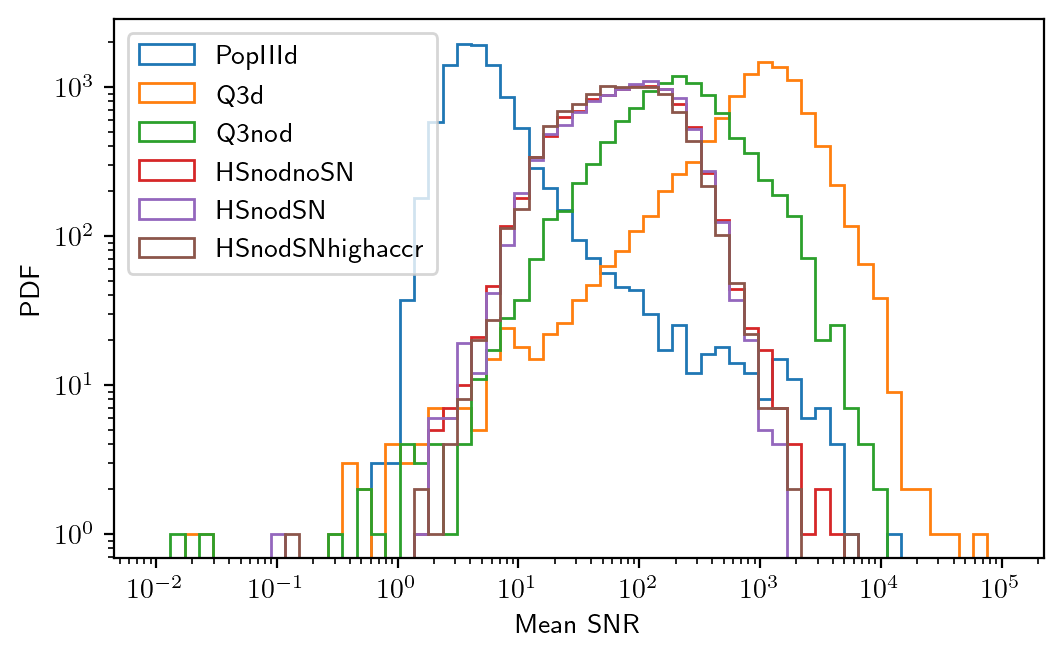

In [24]:
files = [
    ("SecondRun/PopIIId/popIII_SNRLb_final.csv", 7.092047686928647),
    ("SecondRun/Q3d/Q3d_SNRLb_final.csv", 136.01186023421243),
    ("SecondRun/Q3nod/Q3nod_SNRLb_final.csv", 15.215581973187101),
    ("SecondRun/HSnodnoSN/HSnodnoSN_SNRLb_final.csv", 0.25404047565928967),
    ("SecondRun/HSnodSN/HSnodSN_SNRLb_final.csv", 0.27181526086667807),
    ("SecondRun/HSnodSNhighaccr/HSnodSNhighaccr_SNRLb_final.csv", 1.0630494636915455)
]

bins = np.logspace(-2, 5, 60)
plt.figure(figsize=(6,3.5))

for f, n in files:
    df = pd.read_csv(f)
    plt.hist(df["Mean_SNR"], bins=bins, histtype='step', label=f.split("/")[1])

plt.yscale('log')
plt.xscale('log')
plt.xlabel("Mean SNR")
plt.ylabel("PDF")
plt.legend()
plt.show()


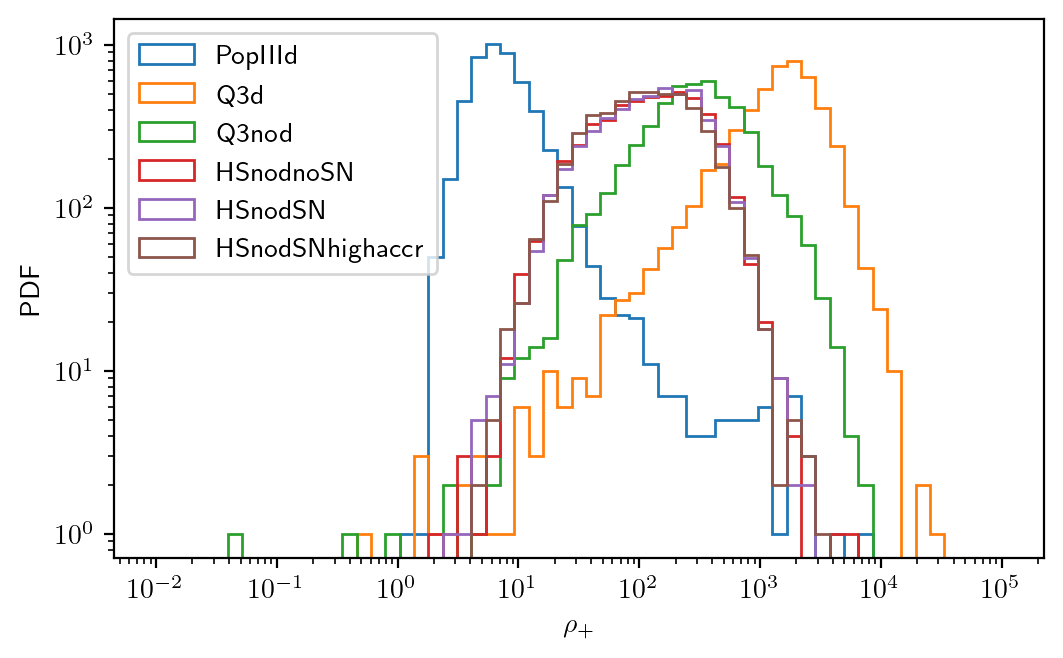

In [27]:
files = [
    ("SecondRun/PopIIId/popIII_z_indep.csv", 7.092047686928647),
    ("SecondRun/Q3d/Q3d_z_indep.csv", 136.01186023421243),
    ("SecondRun/Q3nod/Q3nod_z_indep.csv", 15.215581973187101),
    ("SecondRun/HSnodnoSN/HSnodnoSN_z_indep.csv", 0.25404047565928967),
    ("SecondRun/HSnodSN/HSnodSN_z_indep.csv", 0.27181526086667807),
    ("SecondRun/HSnodSNhighaccr/HSnodSNhighaccr_z_indep.csv", 1.0630494636915455)
]

bins = np.logspace(-2, 5, 60)
plt.figure(figsize=(6,3.5))

for f, n in files:
    df = pd.read_csv(f)
    
    df["x"] = np.random.rand(len(df))
    df["y"] = df["x"]**0.5
    df["xp"] = df["y"] + 1
    df["xm"] = df["y"] - 1
    df["mup"] = 1 + (1 / df["y"]) 
    df["mum"] = 1 - (1 / df["y"]) 
    df["SNRp"] = df["Mean_SNR"] * np.sqrt(np.abs(df["mup"]))
    df["SNRm"] = df["Mean_SNR"] * np.sqrt(np.abs(df["mum"]))
    
    plt.hist(df["SNRp"], bins=bins, histtype='step', label=f.split("/")[1])

plt.yscale('log')
plt.xscale('log')
plt.xlabel(r"$\rho_+$")
plt.ylabel("PDF")
plt.legend()
plt.show()

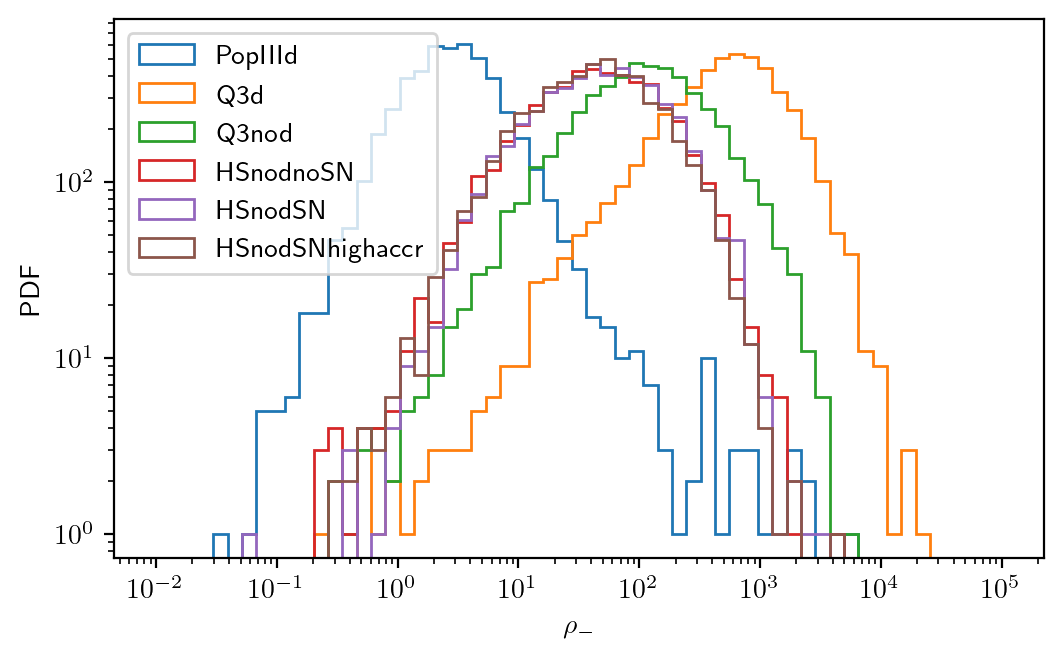

In [28]:
files = [
    ("SecondRun/PopIIId/popIII_z_indep.csv", 7.092047686928647),
    ("SecondRun/Q3d/Q3d_z_indep.csv", 136.01186023421243),
    ("SecondRun/Q3nod/Q3nod_z_indep.csv", 15.215581973187101),
    ("SecondRun/HSnodnoSN/HSnodnoSN_z_indep.csv", 0.25404047565928967),
    ("SecondRun/HSnodSN/HSnodSN_z_indep.csv", 0.27181526086667807),
    ("SecondRun/HSnodSNhighaccr/HSnodSNhighaccr_z_indep.csv", 1.0630494636915455)
]

bins = np.logspace(-2, 5, 60)
plt.figure(figsize=(6,3.5))

for f, n in files:
    df = pd.read_csv(f)
    
    df["x"] = np.random.rand(len(df))
    df["y"] = df["x"]**0.5
    df["xp"] = df["y"] + 1
    df["xm"] = df["y"] - 1
    df["mup"] = 1 + (1 / df["y"]) 
    df["mum"] = 1 - (1 / df["y"]) 
    df["SNRp"] = df["Mean_SNR"] * np.sqrt(np.abs(df["mup"]))
    df["SNRm"] = df["Mean_SNR"] * np.sqrt(np.abs(df["mum"]))
    
    plt.hist(df["SNRm"], bins=bins, histtype='step', label=f.split("/")[1])

plt.yscale('log')
plt.xscale('log')
plt.xlabel(r"$\rho_-$")
plt.ylabel("PDF")
plt.legend()
plt.show()

# Scatter Plots SNR

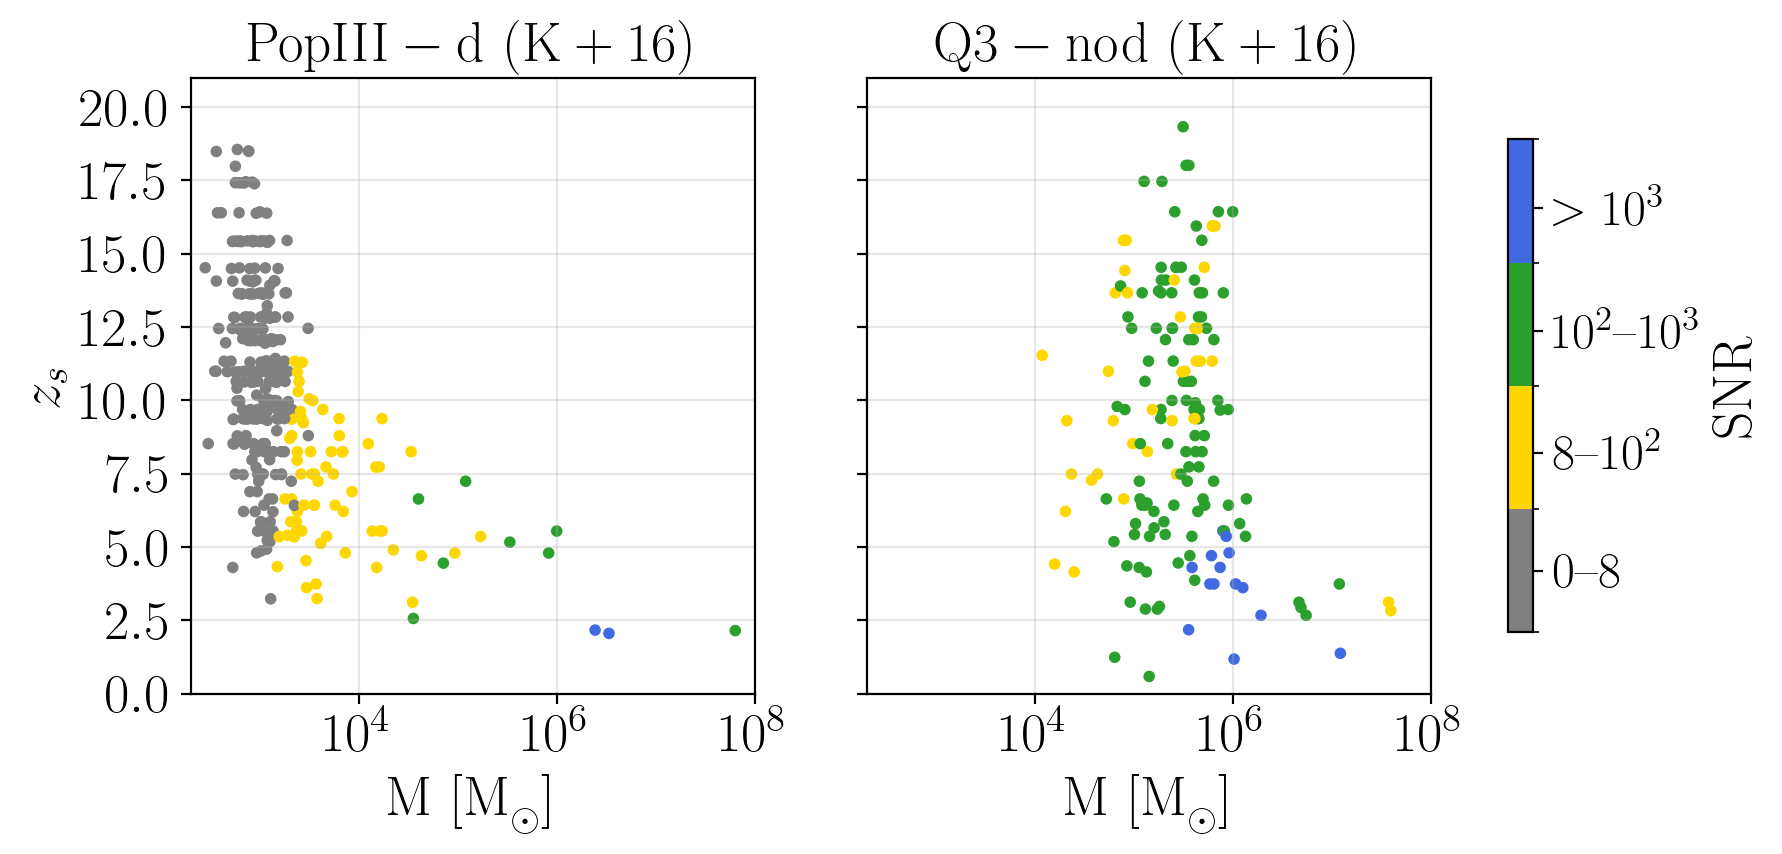

In [201]:
# Unlensed Events
from matplotlib.colors import BoundaryNorm, ListedColormap

df1 = pd.read_csv("SecondRun/PopIIId/popIII_SNRLb_final.csv")
df2 = pd.read_csv("SecondRun/Q3nod/Q3nod_SNRLb_final.csv")

n1 = 1410 / 4
n2 = 657 / 4

df1_sample = df1.sample(n=int(n1), random_state=1)
df2_sample = df2.sample(n=int(n2), random_state=1)

bounds = [0, 8, 100,1000,  10000]
colors = ['grey', 'gold','tab:green', 'royalblue']
cmap = ListedColormap(colors)
norm = BoundaryNorm(bounds, cmap.N)


fig, axs = plt.subplots(1, 2, figsize=(10, 4), sharex=False, sharey=True)

sc0 = axs[0].scatter(
    df1_sample['m1'] + df1_sample['m2'],
    df1_sample['z_merger'],
    c=df1_sample['Mean_SNR'],
    cmap=cmap,
    norm=norm,
    s=10
)
axs[0].set_xscale("log")
axs[0].set_title(r'$\mathrm{PopIII-d\ (K+16)}$', fontsize = 20)
axs[0].set_xlabel(r"$\mathrm{M\ [M}_\odot]$", fontsize = 20)
axs[0].set_ylabel(r"$z_s$", fontsize = 20)
axs[0].grid(alpha=0.3)

axs[1].scatter(
    df2_sample['m1'] + df2_sample['m2'],
    df2_sample['z_merger'],
    c=df2_sample['Mean_SNR'],
    cmap=cmap,
    norm=norm,
    s=10
)
axs[1].set_xscale("log")
axs[1].set_title(r'$\mathrm{Q3-nod\ (K+16)}$', fontsize = 20)
axs[1].set_xlabel(r"$\mathrm{M\ [M}_\odot]$", fontsize = 20)
axs[1].grid(alpha=0.3)

cbar = fig.colorbar(sc0, ax=axs, orientation='vertical', pad=0.05, shrink=0.8)
cbar.set_label(r"$\mathrm{SNR}$", fontsize= 20)
cbar.set_ticks([4, 50, 500, 5000])  
cbar.set_ticklabels(['$0–8$', '$8–10^2$', '$10^2–10^3$', '$>10^3$'])
cbar.ax.tick_params(labelsize=18)

for ax in axs:
    ax.set_xlim(2e2, 1e8)
    ax.set_ylim(0, 21)
    ax.set_yticks(np.arange(0, 21, 2.5))
    ax.tick_params(labelsize=20)

#plt.tight_layout()
plt.savefig("SecondRun/Images/scatterSNR_popIII_Q3nod.pdf" , dpi=300, bbox_inches="tight")
plt.show()

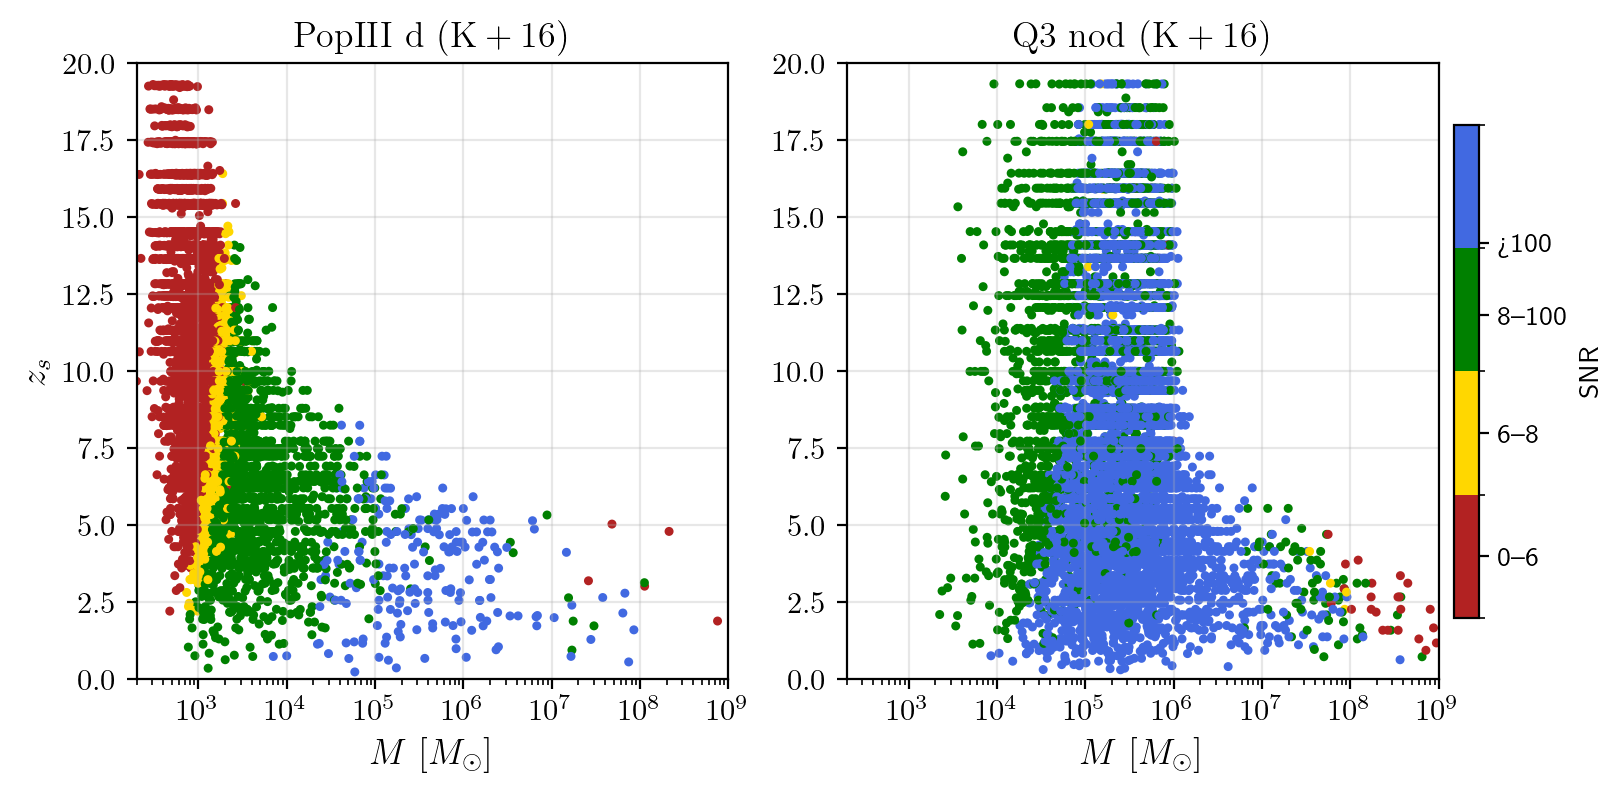

In [23]:
from matplotlib.colors import BoundaryNorm, ListedColormap

df1 = pd.read_csv("SecondRun/PopIIId/popIII_SNRLb_final.csv")
df2 = pd.read_csv("SecondRun/Q3nod/Q3nod_SNRLb_final.csv")

n1 = 1410 / 4
n2 = 657 / 4

df1_sample = df1.sample(n=int(n1), random_state=42)
df2_sample = df2.sample(n=int(n2), random_state=42)


bounds = [0, 6, 8, 100, 10000]
colors = ['firebrick', 'gold', 'green', 'royalblue']
cmap = ListedColormap(colors)
norm = BoundaryNorm(bounds, cmap.N)

fig, axs = plt.subplots(1, 2, figsize=(10, 4), sharex=False)

sc0 = axs[0].scatter(
    df1['m1'] + df1['m2'],
    df1['z_merger'],
    c=df1['Mean_SNR'],
    cmap=cmap,
    norm=norm,
    s=5
)
axs[0].set_xscale("log")
axs[0].set_title(r'$\mathrm{PopIII\ d\ (K+16)}$', fontsize = 13)
axs[0].set_xlabel(r"$M\ [M_\odot]$", fontsize = 13)
axs[0].set_ylabel(r"$z_s$", fontsize = 13)
axs[0].grid(alpha=0.3)

axs[1].scatter(
    df2['m1'] + df2['m2'],
    df2['z_merger'],
    c=df2['Mean_SNR'],
    cmap=cmap,
    norm=norm,
    s=5
)
axs[1].set_xscale("log")
axs[1].set_title(r'$\mathrm{Q3\ nod\ (K+16)}$', fontsize = 13)
axs[1].set_xlabel(r"$M\ [M_\odot]$", fontsize = 13)
axs[1].grid(alpha=0.3)

cbar = fig.colorbar(sc0, ax=axs, orientation='vertical', pad=0.01, shrink=0.8)
cbar.set_label("SNR")
cbar.set_ticks([3, 7, 50, 500])  
cbar.set_ticklabels(['0–6', '6–8', '8–100', '>100'])

axs[0].set_xlim(2e2, 1e9)
axs[1].set_xlim(2e2, 1e9)
axs[0].set_ylim(0, 20)
axs[1].set_ylim(0, 20)
axs[0].set_yticks(np.arange(0, 21, 2.5))
axs[0].tick_params(labelsize=14)
axs[1].set_yticks(np.arange(0, 21, 2.5))
axs[1].tick_params( labelsize=14)

#plt.tight_layout()
plt.show()

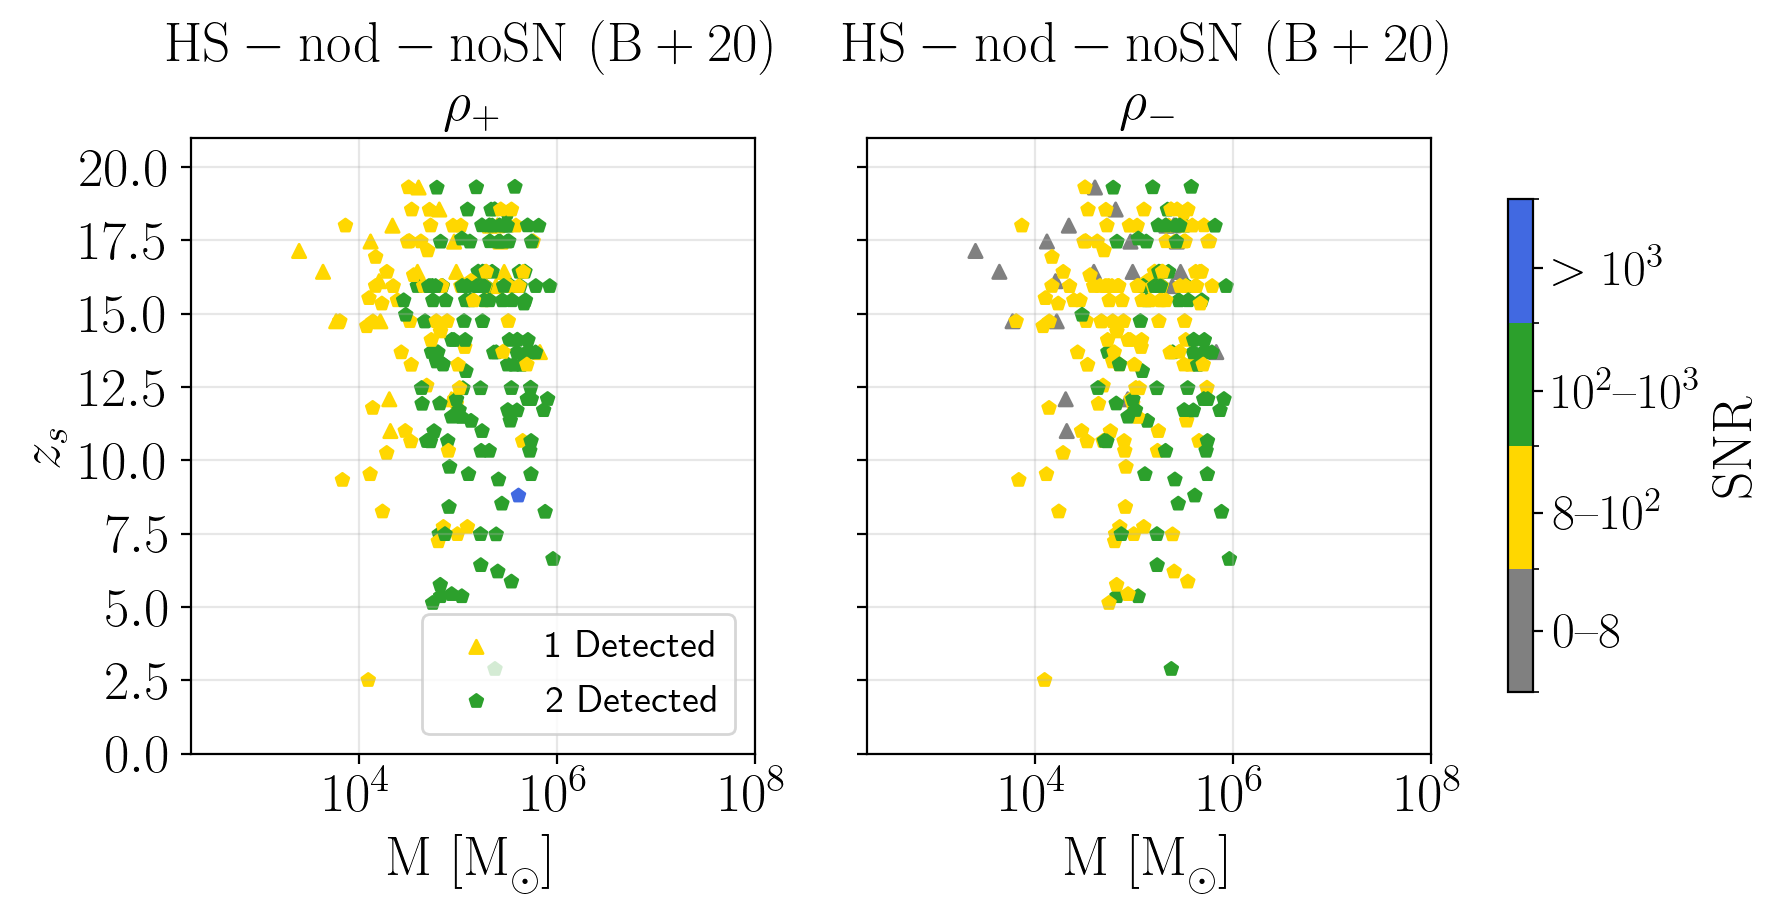

In [200]:
# lensed Events
from matplotlib.colors import BoundaryNorm, ListedColormap

df = pd.read_csv("SecondRun/HSnodnoSN/HSnodnoSN_z_indep.csv")

n = 231

df_sample = df.sample(n=int(n), random_state=101)

df_sample["x"] = np.random.rand(len(df_sample))
df_sample["y"] = df_sample["x"]**0.5
df_sample["xp"] = df_sample["y"] + 1
df_sample["xm"] = df_sample["y"] - 1
df_sample["mup"] = 1 + (1 / df_sample["y"]) 
df_sample["mum"] = 1 - (1 / df_sample["y"]) 
df_sample["SNRp"] = df_sample["Mean_SNR"] * np.sqrt(np.abs(df_sample["mup"]))
df_sample["SNRm"] = df_sample["Mean_SNR"] * np.sqrt(np.abs(df_sample["mum"]))

bounds = [0, 8, 100,1000,  10000]
colors = ['grey', 'gold','tab:green', 'royalblue']
cmap = ListedColormap(colors)
norm = BoundaryNorm(bounds, cmap.N)


cond1 = (df_sample['SNRm'] < 8) & (df_sample['SNRp'] > 8)
cond2 = (df_sample['SNRm'] > 8) & (df_sample['SNRp'] > 8)

fig, axs = plt.subplots(1, 2, figsize=(10, 4), sharex=False, sharey=True)

sc0a = axs[0].scatter(
    df_sample.loc[cond1, 'm1'] + df_sample.loc[cond1, 'm2'],
    df_sample.loc[cond1, 'z_merger'],
    c=df_sample.loc[cond1, 'SNRp'],
    cmap=cmap,
    norm=norm,
    s=23,
    marker="^", 
    label="1 Detected"
)

sc0b = axs[0].scatter(
    df_sample.loc[cond2, 'm1'] + df_sample.loc[cond2, 'm2'],
    df_sample.loc[cond2, 'z_merger'],
    c=df_sample.loc[cond2, 'SNRp'],
    cmap=cmap,
    norm=norm,
    s=23,
    marker="p", 
    label="2 Detected"
)

axs[0].set_xscale("log")
axs[0].set_title(r"$\mathrm{HS-nod-noSN\ (B+20)}$" + "\n" + r"$\rho_+$", fontsize=20, loc="center", multialignment="center")
axs[0].set_xlabel(r"$\mathrm{M\ [M}_\odot]$", fontsize=20)
axs[0].set_ylabel(r"$z_s$", fontsize=20)
axs[0].grid(alpha=0.3)

axs[1].scatter(
    df_sample.loc[cond1, 'm1'] + df_sample.loc[cond1, 'm2'],
    df_sample.loc[cond1, 'z_merger'],
    c=df_sample.loc[cond1, 'SNRm'],
    cmap=cmap,
    norm=norm,
    s=23,
    marker="^"
)

axs[1].scatter(
    df_sample.loc[cond2, 'm1'] + df_sample.loc[cond2, 'm2'],
    df_sample.loc[cond2, 'z_merger'],
    c=df_sample.loc[cond2, 'SNRm'],
    cmap=cmap,
    norm=norm,
    s=23,
    marker="p"
)

axs[1].set_xscale("log")
axs[1].set_title(r"$\mathrm{HS-nod-noSN\ (B+20)}$" + "\n" + r"$\rho_-$", fontsize=20, loc="center", multialignment="center")
axs[1].set_xlabel(r"$\mathrm{M\ [M}_\odot]$", fontsize=20)
axs[1].grid(alpha=0.3)

cbar = fig.colorbar(sc0a, ax=axs, orientation='vertical', pad=0.05, shrink=0.8)
cbar.set_label(r"$\mathrm{SNR}$", fontsize=20)
cbar.set_ticks([4, 50, 500, 5000])  
cbar.set_ticklabels(['$0–8$', '$8–10^2$', '$10^2–10^3$', '$>10^3$'])
cbar.ax.tick_params(labelsize=18)

for ax in axs:
    ax.set_xlim(2e2, 1e8)
    ax.set_ylim(0, 21)
    ax.set_yticks(np.arange(0, 21, 2.5))
    ax.tick_params(labelsize=20)

axs[0].legend(fontsize=14, frameon = True, loc= 'lower right')

plt.savefig("SecondRun/Images/scatterlensedSNR_HSnodnoSN.pdf" , dpi=300, bbox_inches="tight")
plt.show()

# Profundidades Opticas


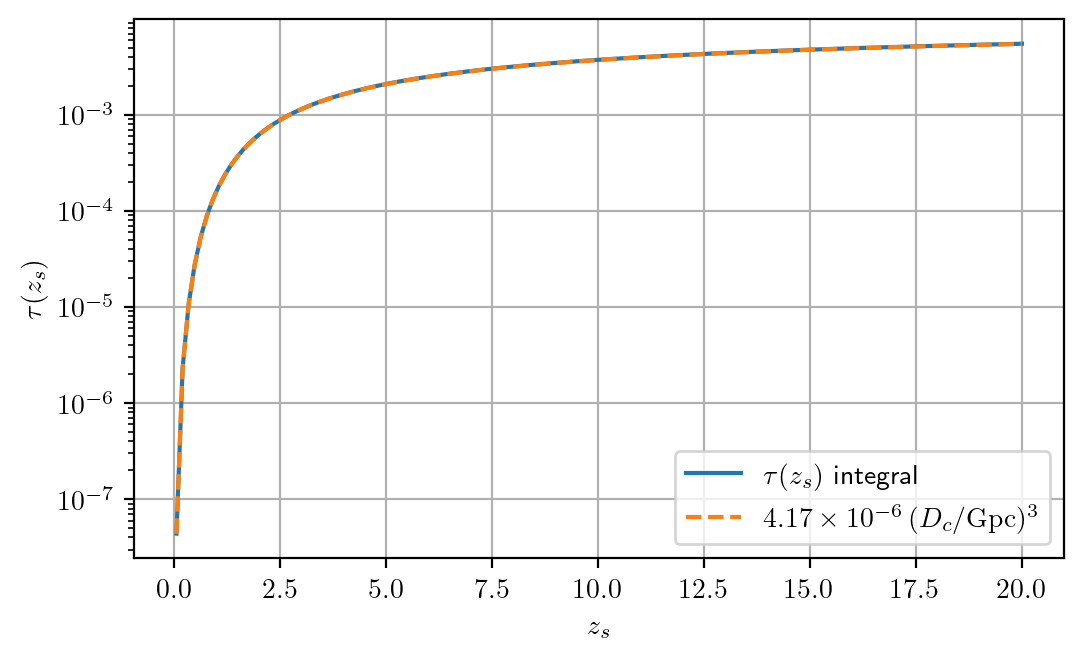

In [113]:
# HARIs 2018

h = 0.7
phi_star0 = 8e-3* (h)**3       
sigma_star = 161               
alpha, beta = 2.32, 2.67
nu_n, nu_v = 0, 0             
c_km_s = 3.0e5                   

prefactor = (16 * np.pi**3 * phi_star0 * gamma((4+alpha)/beta) / gamma(alpha/beta) * (sigma_star / c_km_s)**4)

def integrand(zL, zS):
    DL = cosmo.angular_diameter_distance(zL).to(u.Mpc).value
    DS = cosmo.angular_diameter_distance(zS).to(u.Mpc).value
    DLS = cosmo.angular_diameter_distance_z1z2(zL, zS).to(u.Mpc).value
    Hz = cosmo.H(zL).to(u.km/u.s/u.Mpc).value
    
    evo = (1.0 + zL)**(2.0 + nu_n + 4.0*nu_v)
    
    geom = (DL * DLS / DS)**2
    return evo * (c_km_s / Hz) * geom

def tau(zS):
    if zS <= 0:
        return 0.0
    val, _ = quad(integrand, 0.0, zS, args=(zS,), epsabs=0, epsrel=1e-5, limit=200)
    return prefactor * val

z_grid = np.linspace(0.05, 20.0, 140)
tau_vals = np.array([tau(z) for z in z_grid])

Dc = cosmo.comoving_distance(z_grid).to(u.Gpc).value  # comoving line-of-sight distance in Gpc
tau_approx = 4.17e-6 * Dc**3

plt.figure(figsize=(6,3.5))
plt.plot(z_grid, tau_vals, label=r'$\tau(z_s)$ integral')
plt.plot(z_grid, tau_approx, linestyle='--', label=r'$4.17\times10^{-6}\,(D_c/\mathrm{Gpc})^3$')
plt.yscale('log')
plt.xlabel(r"$z_s$")
plt.ylabel(r"$\tau(z_s)$")
plt.grid(True)
plt.legend()
plt.show()

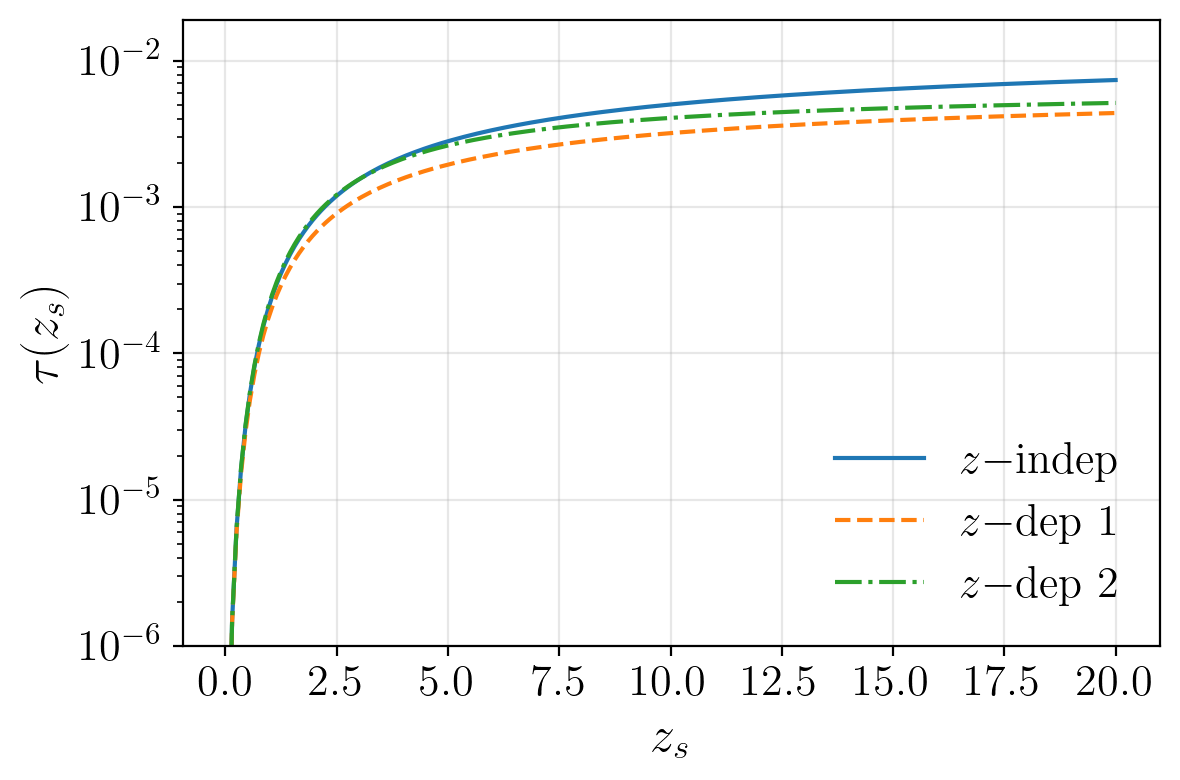

In [7]:
h = cosmo.h
H0 = cosmo.H0.value 
phi_star0 = 2.099e-2 * (h/0.7)**3   # Mpc^-3
sigma_star0 = 113.78                 # km/s
alpha, beta = 0.94, 1.85
nu_n, nu_v = -1.18,0.18               
c_km_s = 3.0e5                      # km/s

z_grid = np.linspace(0.05, 20.0, 200)

# --z independent model--

def tau_indep(zS):    
    F_star = 0.000489386
    Dc = cosmo.comoving_distance(zS).to(u.Mpc).value  
    return F_star  * (H0 * Dc / c_km_s) ** 3

tau_indep_vals = np.array([tau_indep(z) for z in z_grid])

# --z dependent 1--

prefactor = (16 * np.pi**3 * phi_star0 *c_km_s* gamma((4+alpha)/beta) / gamma(alpha/beta) * (sigma_star0 / c_km_s)**4)

def integrand(zL, zS):
    DL = cosmo.angular_diameter_distance(zL).to(u.Mpc).value
    DS = cosmo.angular_diameter_distance(zS).to(u.Mpc).value
    DLS = cosmo.angular_diameter_distance_z1z2(zL, zS).to(u.Mpc).value
    
    Hz = cosmo.H(zL).to(u.km/u.s/u.Mpc).value
    
    evo = (1.0 + zL)**(2.0 + nu_n + 4.0*nu_v)
    
    geom = (DL * DLS / DS)**2
    return evo / Hz * geom

def tau_dep1(zS):
    if zS <= 0:
        return 0.0
    val, _ = quad(integrand, 0.0, zS, args=(zS,), epsabs=0, epsrel=1e-5, limit=200)
    return prefactor * val

tau_dep1_vals = np.array([tau_dep1(z) for z in z_grid])

# -- z dependent 2 --

def phi_indep(sigma):    
    phi_indep = phi_star0 * (sigma/sigma_star0)**alpha * np.exp(-(sigma/sigma_star0)**beta) * beta/(gamma(alpha/beta) * sigma)
    return phi_indep

def phi_dep2(sigma, z):
    a0, a1, a2    = 7.391498,  5.729400,  -1.120552
    al0, al1, al2 = -6.863393, -5.273271,  1.104114
    be0, be1, be2 = 2.852083,  1.255696,  -0.286638
    ga0, ga1, ga2 = 0.067032,  -0.048683,  0.007648

    def phi_hyd(sigma, z):
        A_hyd     = a0  + a1*z  + a2*z**2
        alpha_hyd = al0 + al1*z + al2*z**2
        beta_hyd  = be0 + be1*z + be2*z**2
        gamma_hyd = ga0 + ga1*z + ga2*z**2
        sigma_star_hyd = 10**gamma_hyd

        x = np.log10(sigma / sigma_star_hyd)
        n = 10**(A_hyd + alpha_hyd*x + beta_hyd*x**2 - np.exp(x))

        phi1 = n/sigma * (alpha_hyd + 2*beta_hyd*x - np.exp(x))

        return phi1

    phi_z = phi_hyd(sigma, z)
    phi_0 = phi_hyd(sigma, 0.0)
    ratio = phi_z / phi_0

    return ratio * phi_indep(sigma)

def sigma_integral(zL):
    integrand = lambda s: s**4 * phi_dep2(s, zL)
    val, _ = quad(integrand, 60, 1e3, epsrel=1e-5)
    return val

def z_integral(zL, zS):
    DL = cosmo.angular_diameter_distance(zL).to(u.Mpc).value
    DS = cosmo.angular_diameter_distance(zS).to(u.Mpc).value
    DLS = cosmo.angular_diameter_distance_z1z2(zL, zS).to(u.Mpc).value
    Hz = cosmo.H(zL).to(u.km/u.s/u.Mpc).value
    
    geom = (DL*DLS/DS)**2
    return (1+zL)**2 / Hz * geom * sigma_integral(zL)

def tau_dep2(zS):
    pref = 16*np.pi**3 / c_km_s**3
    val, _ = quad(z_integral, 0, zS, args=(zS,), epsrel=1e-4, limit=200)
    return pref * val

tau_dep2_vals = np.array([tau_dep2(z) for z in z_grid])


# -- plot --

plt.figure(figsize=(6,4))

plt.plot(z_grid, tau_indep_vals, linestyle='-', label=r'$z \mathrm{-indep}$', lw = 1.5)
plt.plot(z_grid, tau_dep1_vals, label=r'$z\mathrm{-dep\ 1}$', ls = '--', lw = 1.5)
plt.plot(z_grid, tau_dep2_vals, label=r'$z\mathrm{-dep\ 2}$', ls = '-.', lw = 1.5)

plt.yscale('log')
plt.xlabel(r"$z_s$", fontsize = 18)
plt.ylabel(r"$\tau(z_s)$",fontsize = 18)
plt.ylim(1e-6, 1.9e-2)
plt.grid(True, alpha= 0.3)
plt.xticks(np.arange(0, 21, 2.5))
plt.tick_params(labelsize = 16)
plt.legend(fontsize = 16, frameon=False)
plt.tight_layout()

#plt.savefig("SecondRun/Images/tau_3models.pdf", dpi=300)
plt.show()

In [8]:
a = tau_indep(20)
b = tau_dep1(20)
c = tau_dep2(20)  # c= 0.00533 integrando desde 1 km/s

a, b, c

(np.float64(0.00738435258682515),
 np.float64(0.004394015957847792),
 0.005150456077676563)

# Redshift distributions

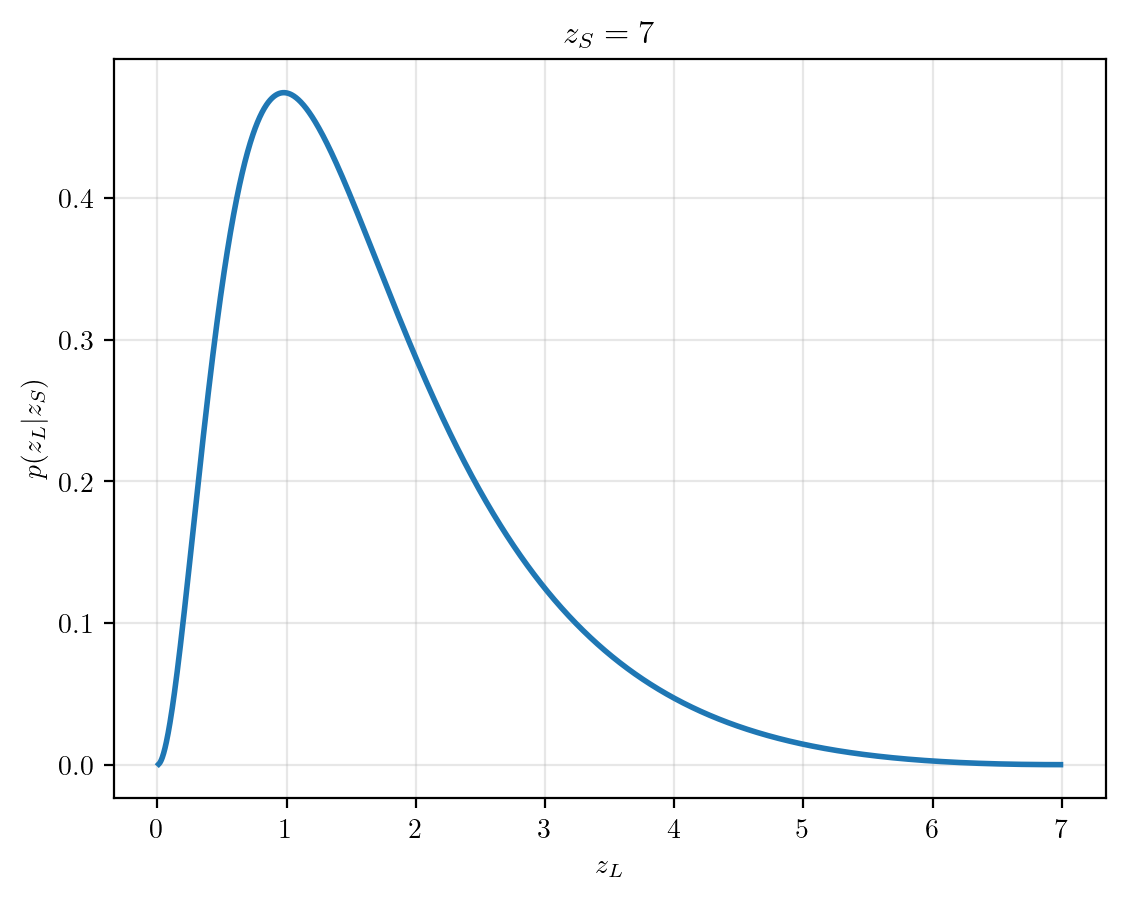

In [45]:
# grid para la distancia del lens 2 (redshift dependant)

zs = 7 
nun, nuv = 0,0

zl = np.linspace(0.01, zs-0.01, 2000)  

Dc_s = cosmo.comoving_distance(zs).value      
Dc_l = cosmo.comoving_distance(zl).value      
H_l  = cosmo.H(zl).value  

r = Dc_l / Dc_s

p = ((1 + zl)**(nun + 4*nuv)) * (r**2 * (1 - r)**2) / H_l

dz = np.gradient(zl)
p_norm = p / np.sum(p * dz)

plt.plot(zl, p_norm, lw=2)
plt.xlabel(r"$z_L$")
plt.ylabel(r"$p(z_L|z_S)$")
plt.title(f" $z_S={zs}$")
plt.grid(True, alpha=0.3)
plt.show()

In [89]:
# calculo del merger rate para samplear según peso

file_path = "HS-nod-SN-high-accr_signed.dat.bz2"

column_names = ["z_merger", "m1", "m2", "a1", "a2", "alpha", "beta", "gamma", "psi", "afin", "mfin", "vkick", "vesc_halo", "vesc_bar", "Mcluster", "Mdisk_stars", "Mdisk_gas", "Mbulge_stars", "Mbulge_gas", "MNSC", "Mreservoir", "Mhalo_final", "halo_density"]

data = pd.read_csv(file_path, sep='\s+', names=column_names)

c = 9.72e-15  # Velocidad de la luz en Mpc/s
 
def luminosity_distance(z):
    return cosmo.luminosity_distance(z).value  # (Entrega resultado en Mpc)
    
data["Dl_s"] = data["z_merger"].apply(luminosity_distance)

data["d2N_dzdt"] = (4 * np.pi * c * data["halo_density"] * data["Dl_s"]**2 / ((1 + data["z_merger"])**2))

data.to_csv("HS-nod-SN-high-accr_signed.dat.bz2", index=False)

In [112]:
# sampleo de 10000 eventos según peso de MR

data = pd.read_csv('HSnodB20SN_extrapolated_signed.dat.bz2')

time_factor = 31558149.8 * 4       # Pensado para 4 años (Año sideral en segundos x 4)

data["event_probability"] = data["d2N_dzdt"] * time_factor

probabilities = data["event_probability"] / data["event_probability"].sum()  # Normalizar las probabilidades

expected_events = int(data["event_probability"].sum())

print(f"Eventos esperados en 4 años: {expected_events}")

sampled_events = data.sample(n=10000, weights=probabilities, replace=False)
selected_columns = ["m1", "m2", "a1", "a2","Dl_s", "z_merger", "alpha", "beta", "gamma", "halo_density","d2N_dzdt"]  # Esto filtra dejando solo las columnas de interes 
sampled_events = sampled_events[selected_columns]

mask = sampled_events['m1'] < sampled_events['m2']                          # Esto reordena las columnas de manera que siempre se cumpla que m1>m2
sampled_events.loc[mask, ['m1', 'm2']] = sampled_events.loc[mask, ['m2', 'm1']].values
assert (sampled_events['m1'] >= sampled_events['m2']).all(), "Todavía hay casos donde m2 > m1"

sampled_events.to_csv("SecondRun/HSnodSN_redshifts.csv", index=False)


Eventos esperados en 4 años: 36815


In [113]:
# Calculo de redshifts y distancias 

from tqdm import tqdm
tqdm.pandas() 

nun, nuv = -1.18, 0.18
cmpc = 9.72e-15  # Velocidad luz Mpc/s

df = pd.read_csv("SecondRun/HSnodSN_redshifts.csv")  

zl_grid = np.linspace(0.01, df['z_merger'].max()-0.01,1000)

df["Dc_s"] = cosmo.comoving_distance(df["z_merger"]).value  
df["Da_s"] = cosmo.angular_diameter_distance(df["z_merger"]).value

# -- redshift independant (lens 1) --
df["Dc_l1"] = df["Dc_s"] * np.random.beta(3, 3, size=len(df))
df["z_l1"] = df["Dc_l1"].progress_apply(lambda d: z_at_value(cosmo.comoving_distance, d * u.Mpc).value)
df["Da_l1"] = cosmo.angular_diameter_distance(df["z_l1"]).value
df["Da_l1s"] = cosmo.angular_diameter_distance_z1z2(df["z_l1"], df["z_merger"]).value
#df["delta_t1"] = ((32 * np.pi**2) / cmpc) * (df["sigma"] / ckm)**4 * (df["aDl"] * df["aDls"] / df["aDs"]) * (1 + df["z_lens"])
#df["timedelay"] = df["y"] * df["delta_t1"]

# -- redshift dependant 1 (lens 2) --
def pdf_zl_given_zs(zs, zl_grid):
    Dc_s = cosmo.comoving_distance(zs).value
    Dc_l = cosmo.comoving_distance(zl_grid).value
    H_l  = cosmo.H(zl_grid).value
    r = Dc_l / Dc_s
    pdf =((1 + zl_grid)**(nun + 4*nuv)) * (r**2 * (1-r)**2) / H_l
    pdf /= np.trapezoid(pdf, zl_grid)
    return pdf

def sample_zl(zs, ngrid=200):
    zl_grid = np.linspace(0.01, zs-0.01, ngrid)
    pdf = pdf_zl_given_zs(zs, zl_grid)
    cdf = np.cumsum((pdf[:-1]+pdf[1:]) * np.diff(zl_grid)/2)
    cdf = np.concatenate([[0], cdf/cdf[-1]])
    u = np.random.rand()
    return np.interp(u, cdf, zl_grid)

df['z_l2'] = df['z_merger'].apply(sample_zl)
df["Dc_l2"] = cosmo.comoving_distance(df["z_l2"]).value  
df["Da_l2"] = cosmo.angular_diameter_distance(df["z_l2"]).value
df["Da_l2s"] = cosmo.angular_diameter_distance_z1z2(df["z_l2"], df["z_merger"]).value
#df["delta_t2"] = ((32 * np.pi**2) / cmpc) * (df["sigma"] / ckm)**4 * (df["aDl"] * df["aDls"] / df["aDs"]) * (1 + df["z_lens"])
#df["timedelay"] = df["y"] * df["delta_t2"]

df.to_csv("SecondRun/HSnodSN_redshifts.csv", index=False)

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10000/10000 [00:09<00:00, 1000.10it/s]


In [92]:
# -- redshift dependant 2 (lens 3) --

def phi_indep(sigma):
    phi_star0 = 2.099e-2 * (cosmo.h/0.7)**3
    sigma_star = 113.78
    alpha, beta = 0.94, 1.85
    return phi_star0*(sigma/sigma_star)**alpha*np.exp(-(sigma/sigma_star)**beta)*beta/(gamma(alpha/beta)*sigma)

def phi_dep2(sigma, z):
    a0, a1, a2   = 7.391498, 5.729400, -1.120552
    al0, al1, al2 = -6.863393, -5.273271, 1.104114
    be0, be1, be2 = 2.852083, 1.255696, -0.286638
    ga0, ga1, ga2 = 0.067032, -0.048683, 0.007648

    def phi_hyd(sigma, z):
        A_hyd     = a0  + a1*z  + a2*z**2
        alpha_hyd = al0 + al1*z + al2*z**2
        beta_hyd  = be0 + be1*z + be2*z**2
        gamma_hyd = ga0 + ga1*z + ga2*z**2
        sigma_star_hyd = 10**gamma_hyd

        x = np.log10(sigma / sigma_star_hyd)
        n = 10**(A_hyd + alpha_hyd*x + beta_hyd*x**2 - np.exp(x))

        dlogn_dx = alpha_hyd + 2*beta_hyd*x - np.exp(x)
        dlogn_dsigma = dlogn_dx / (sigma * np.log(10))
        dndsigma = n * np.log(10) * dlogn_dsigma
        return -dndsigma

    phi_z = phi_hyd(sigma, z)
    phi_0 = phi_hyd(sigma, 0.0)
    ratio = phi_z / phi_0

    return ratio * phi_indep(sigma)

def sigma_integral(zL):
    integrand = lambda s: s**4 * phi_dep2(s, zL)
    val, _ = quad(integrand, 1, 1e3, epsrel=1e-5)
    return val

def build_sigma_interp(zmin=0.01, zmax=20, ngrid=100):
    z_vals = np.linspace(zmin, zmax, ngrid)
    sig_vals = np.array([sigma_integral(z) for z in z_vals])
    return interp1d(z_vals, sig_vals, kind="cubic", bounds_error=False, fill_value="extrapolate")

sigma_interp = build_sigma_interp()

def pdf_zl_given_zs(zs, zl_grid):
    Dc_s = cosmo.comoving_distance(zs).value
    Dc_l = cosmo.comoving_distance(zl_grid).value
    H_l  = cosmo.H(zl_grid).value
    r = Dc_l / Dc_s
    sig_vals = sigma_interp(zl_grid)
    pdf =(r**2 * (1-r)**2) / H_l * sig_vals
    norm = np.trapezoid(pdf, zl_grid)
    if norm == 0:
        return np.zeros_like(pdf)
    return pdf / norm

def sample_zl(zs, ngrid=200):
    zl_grid = np.linspace(0.01, zs-0.01, ngrid)
    pdf = pdf_zl_given_zs(zs, zl_grid)
    cdf = np.cumsum((pdf[:-1]+pdf[1:]) * np.diff(zl_grid)/2)
    cdf = np.concatenate([[0], cdf/cdf[-1]])
    u = np.random.rand()
    return np.interp(u, cdf, zl_grid)

df = pd.read_csv("SecondRun/HSnodSNhighaccr/HSnodSNhighaccr_SNRLb_final.csv")

df['z_l3'] = df['z_merger'].apply(sample_zl)
df["Dc_l3"] = cosmo.comoving_distance(df["z_l3"]).value  
df["Da_l3"] = cosmo.angular_diameter_distance(df["z_l3"]).value
df["Da_l3s"] = cosmo.angular_diameter_distance_z1z2(df["z_l3"], df["z_merger"]).value

df.to_csv("SecondRun/HSnodSNhighaccr/HSnodSNhighaccr_SNRLb_final.csv", index=False)


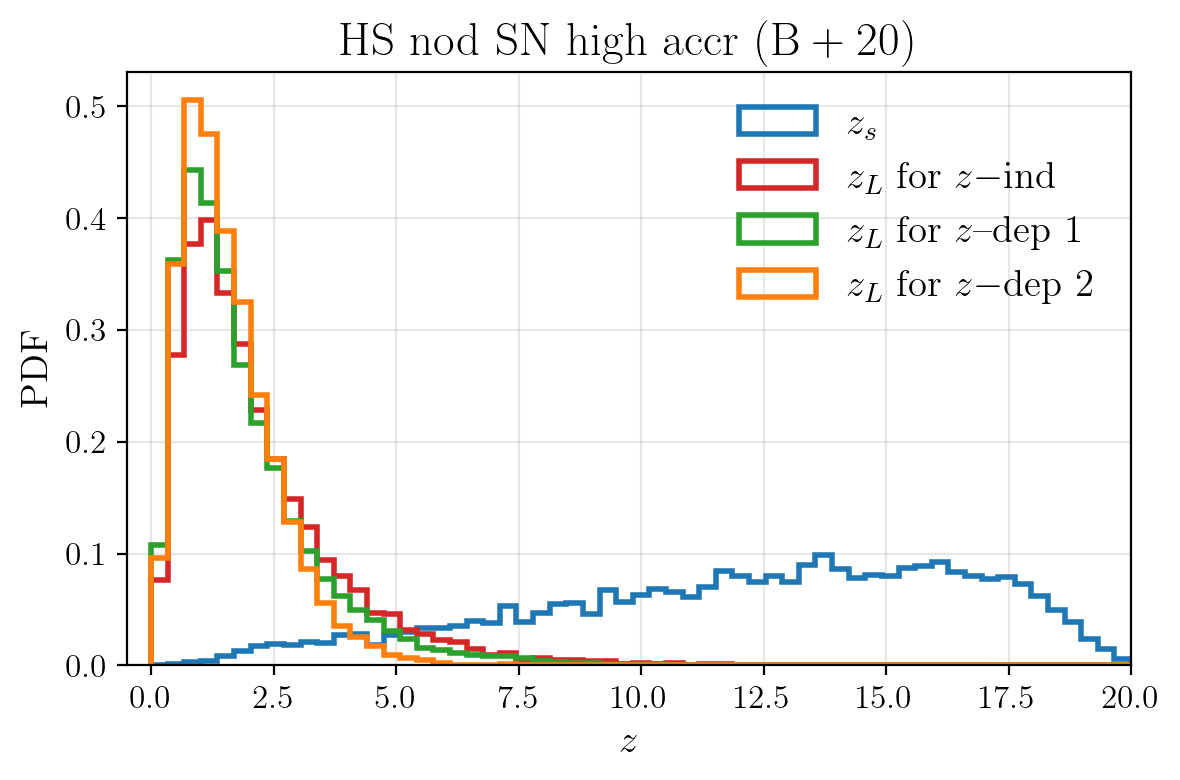

Porcentaje de eventos con z_l1 < 1: 24.14
Porcentaje de eventos con z_l1 < 3: 77.73
Porcentaje de eventos con z_l1 < 6: 96.46000000000001
Porcentaje de eventos con z_l2 < 1: 30.259999999999998
Porcentaje de eventos con z_l2 < 3: 83.11
Porcentaje de eventos con z_l2 < 6: 97.78
Porcentaje de eventos con z_l3 < 1: 31.5
Porcentaje de eventos con z_l3 < 3: 91.07
Porcentaje de eventos con z_l3 < 6: 99.86


In [34]:
# --plots--

bins = np.linspace(0, 20, 60) 

df = pd.read_csv("SecondRun/HSnodSNhighaccr/HSnodSNhighaccr_SNRLb_final.csv")

df["z_merger_noisy"] = df["z_merger"] + np.random.normal(0, 0.55, len(df))

plt.figure(figsize=(6, 4))
plt.title(r'$\mathrm{HS\ nod\ SN\ high\ accr\ (B+20)}$', fontsize=17)

plt.hist(df["z_merger_noisy"], bins=bins, histtype='step', linewidth=2, ls = '-', color='tab:blue', label=r'$z_s$', density= True)
plt.hist(df["z_l1"], bins=bins, histtype='step',           linewidth=2, ls = '-', color='tab:red', label=r'$z_L \mathrm{\ for\ } z \mathrm{-ind}$', density= True)
plt.hist(df["z_l2"],  bins=bins, histtype='step',          linewidth=2, ls = '-', color='tab:green', label=r'$z_L \mathrm{\ for\ } z \mathrm{–dep\ 1}$', density= True)
plt.hist(df["z_l3"],  bins=bins, histtype='step',          linewidth=2, ls = '-', color='tab:orange', label=r'$z_L \mathrm{\ for\ } z \mathrm{-dep\ 2}$', density= True)


plt.xlabel(r'$z$', fontsize=14)
plt.ylabel(r'$\mathrm{PDF}$', fontsize=14)
plt.xticks(np.arange(0, 21, 2.5)) 
plt.tick_params(labelsize=12)
plt.grid(visible=None, which='major', axis='both', alpha=0.3)
plt.legend(frameon=False, fontsize=14)
plt.xlim(-0.5, 20)
#plt.savefig("Images/zlzs_HSnodSNhighaccr.pdf", dpi=300, bbox_inches="tight")
plt.tight_layout()
plt.show()

N = len(df)

print("Porcentaje de eventos con z_l1 < 1:", (df["z_l1"].lt(1).sum() / N) * 100)
print("Porcentaje de eventos con z_l1 < 3:", (df["z_l1"].lt(3).sum() / N) * 100)
print("Porcentaje de eventos con z_l1 < 6:", (df["z_l1"].lt(6).sum() / N) * 100)
print("Porcentaje de eventos con z_l2 < 1:", (df["z_l2"].lt(1).sum() / N) * 100)
print("Porcentaje de eventos con z_l2 < 3:", (df["z_l2"].lt(3).sum() / N) * 100)
print("Porcentaje de eventos con z_l2 < 6:", (df["z_l2"].lt(6).sum() / N) * 100)
print("Porcentaje de eventos con z_l3 < 1:", (df["z_l3"].lt(1).sum() / N) * 100)
print("Porcentaje de eventos con z_l3 < 3:", (df["z_l3"].lt(3).sum() / N) * 100)
print("Porcentaje de eventos con z_l3 < 6:", (df["z_l3"].lt(6).sum() / N) * 100)

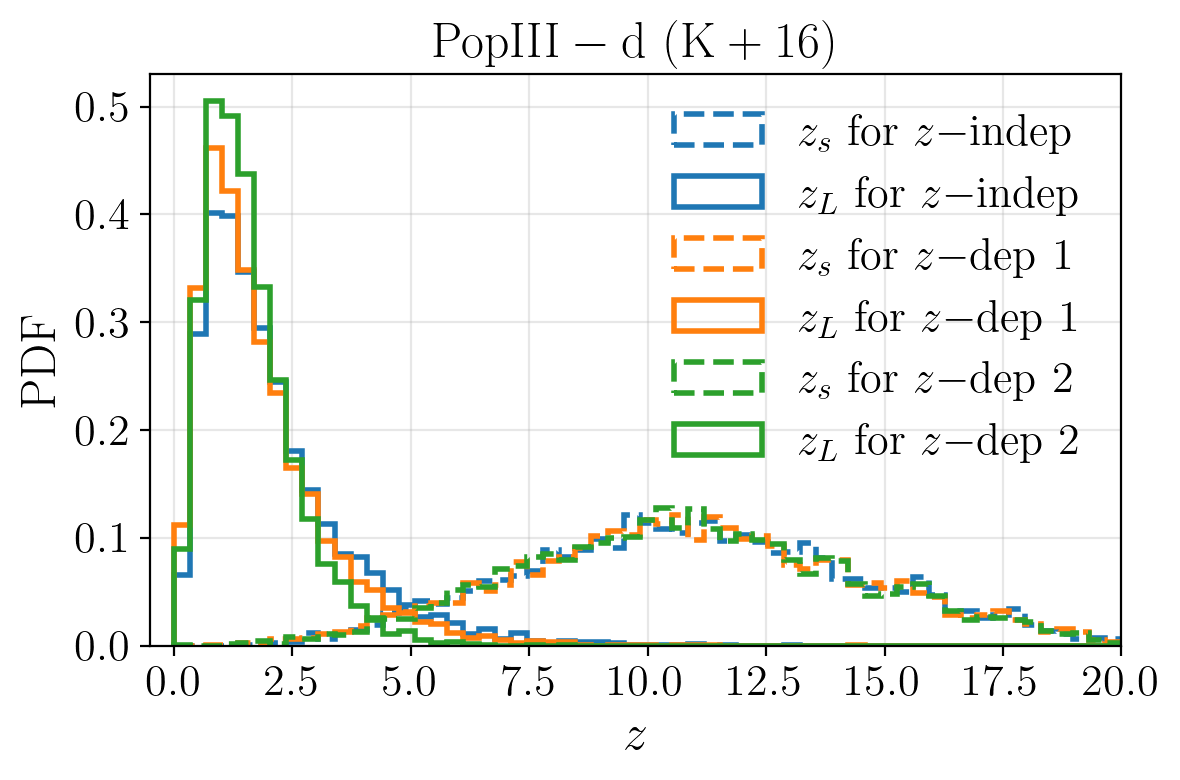

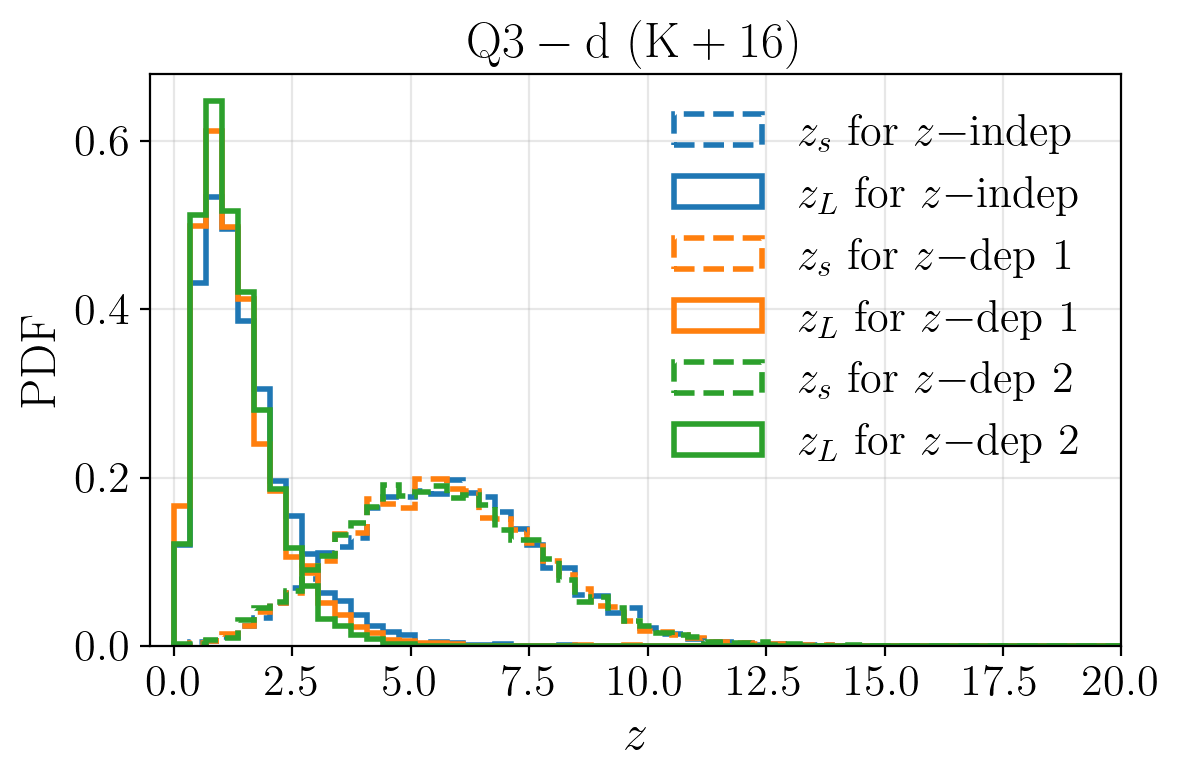

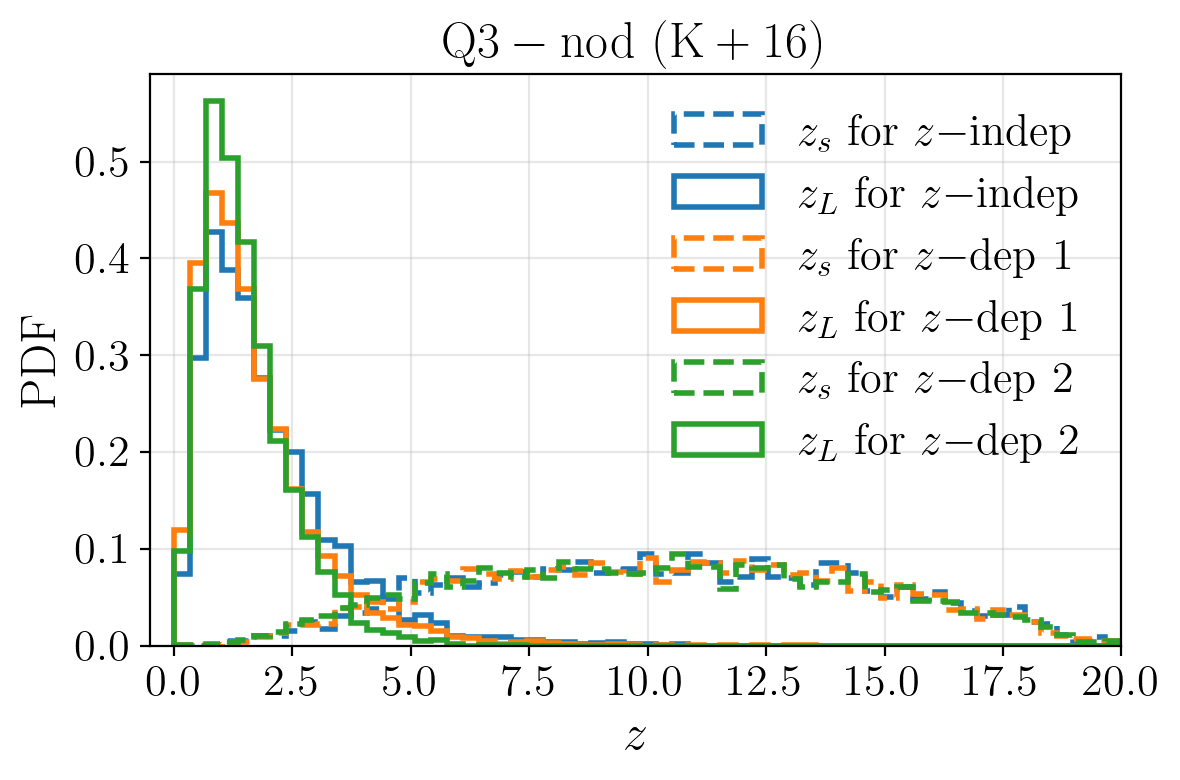

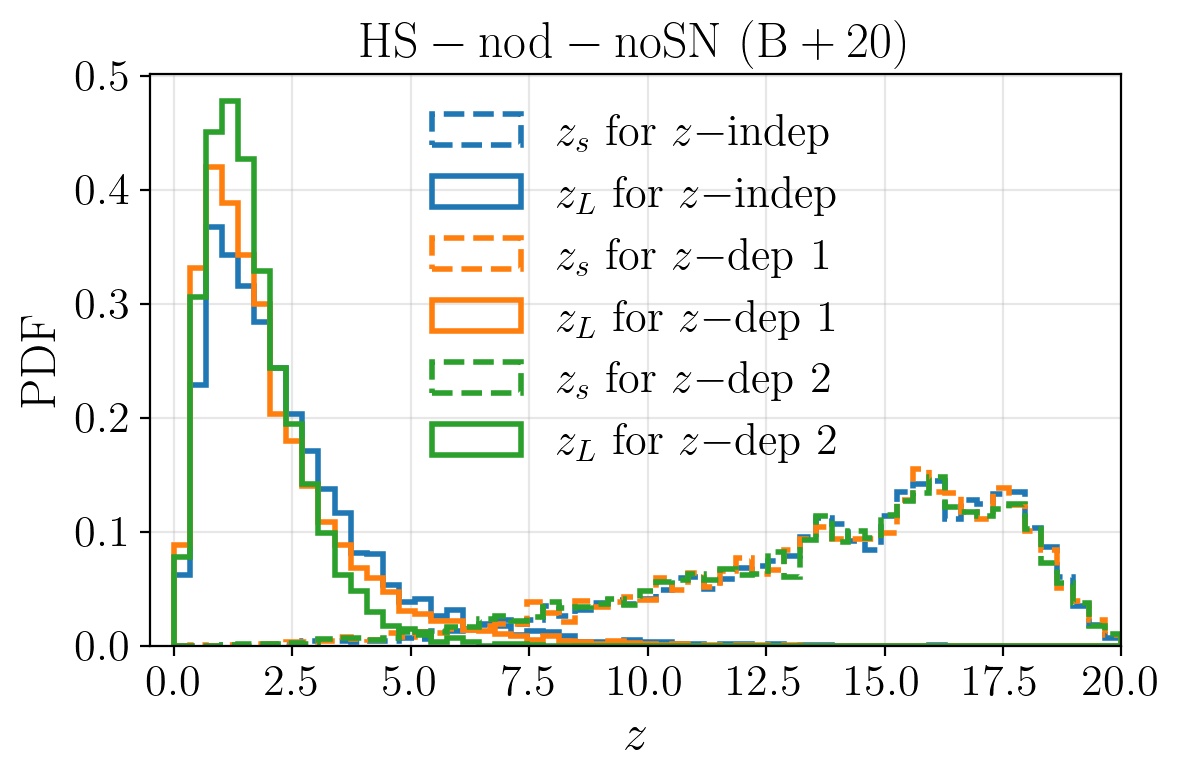

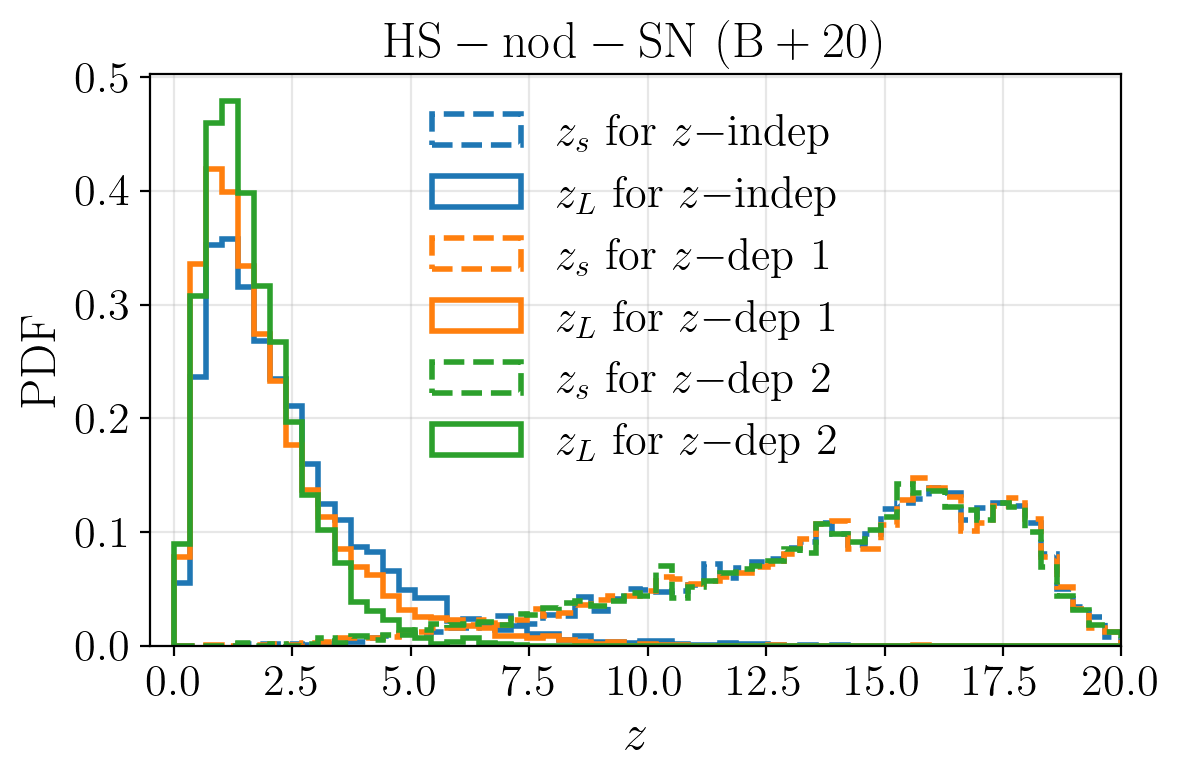

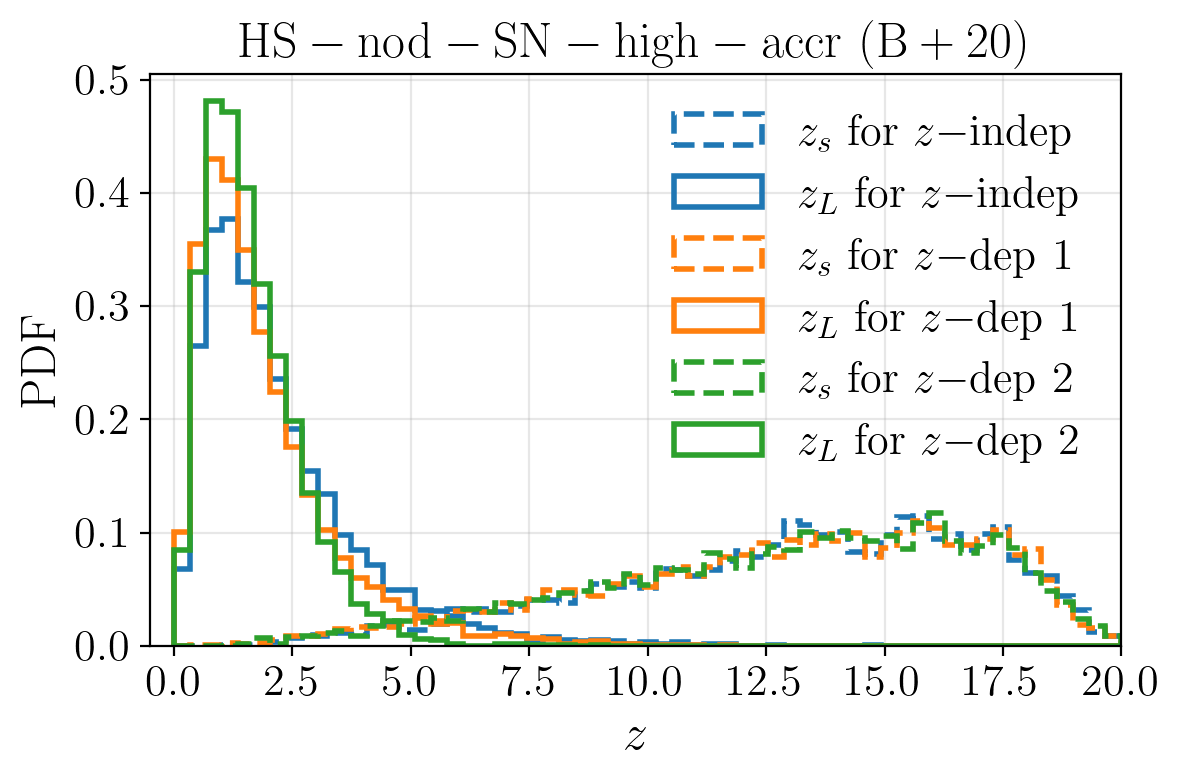

In [126]:
# --plots--

bins = np.linspace(0, 20, 60) 

paths= [("SecondRun/PopIIId/popIII_z_indep.csv","SecondRun/PopIIId/popIII_z_dep1.csv","SecondRun/PopIIId/popIII_z_dep2.csv",'PopIII-d\ (K+16)', "popIIId"),
        ("SecondRun/Q3d/Q3d_z_indep.csv","SecondRun/Q3d/Q3d_z_dep1.csv","SecondRun/Q3d/Q3d_z_dep2.csv",'Q3-d\ (K+16)', "Q3d"),
        ("SecondRun/Q3nod/Q3nod_z_indep.csv","SecondRun/Q3nod/Q3nod_z_dep1.csv","SecondRun/Q3nod/Q3nod_z_dep2.csv",'Q3-nod\ (K+16)', "Q3nod"),
        ("SecondRun/HSnodnoSN/HSnodnoSN_z_indep.csv","SecondRun/HSnodnoSN/HSnodnoSN_z_dep1.csv","SecondRun/HSnodnoSN/HSnodnoSN_z_dep2.csv",'HS-nod-noSN\ (B+20)', "HSnodnoSN"),
        ("SecondRun/HSnodSN/HSnodSN_z_indep.csv","SecondRun/HSnodSN/HSnodSN_z_dep1.csv","SecondRun/HSnodSN/HSnodSN_z_dep2.csv",'HS-nod-SN\ (B+20)', "HSnodSN"),
        ("SecondRun/HSnodSNhighaccr/HSnodSNhighaccr_z_indep.csv","SecondRun/HSnodSNhighaccr/HSnodSNhighaccr_z_dep1.csv","SecondRun/HSnodSNhighaccr/HSnodSNhighaccr_z_dep2.csv",'HS-nod-SN-high-accr\ (B+20)', "HSnodSNhighaccr")    
]

for file1, file2, file3, title, path in paths:
    df1 = pd.read_csv(file1)
    df2 = pd.read_csv(file2)
    df3 = pd.read_csv(file3)
    
    df1["z_merger_noisy"] = df1["z_merger"] + np.random.normal(0, 0.55, len(df1))
    df2["z_merger_noisy"] = df2["z_merger"] + np.random.normal(0, 0.55, len(df2))
    df3["z_merger_noisy"] = df3["z_merger"] + np.random.normal(0, 0.55, len(df3))
    
    plt.figure(figsize=(6, 4))
    plt.title(rf'$\mathrm{{{title}}}$', fontsize=18)
    
    plt.hist(df1["z_merger_noisy"], bins=bins, histtype='step', linewidth=2, ls = '--', color='tab:blue', label=r'$z_s \mathrm{\ for\ } z \mathrm{-indep}$', density= True)
    plt.hist(df1["z_l1"], bins=bins, histtype='step',           linewidth=2, ls = '-', color='tab:blue', label=r'$z_L \mathrm{\ for\ } z \mathrm{-indep}$', density= True)

    plt.hist(df2["z_merger_noisy"], bins=bins, histtype='step', linewidth=2, ls = '--', color='tab:orange', label=r'$z_s \mathrm{\ for\ } z \mathrm{-dep\ 1}$', density= True)
    plt.hist(df2["z_l2"],  bins=bins, histtype='step',          linewidth=2, ls = '-', color='tab:orange', label=r'$z_L \mathrm{\ for\ } z \mathrm{-dep\ 1}$', density= True)

    plt.hist(df3["z_merger_noisy"], bins=bins, histtype='step', linewidth=2, ls = '--', color='tab:green', label=r'$z_s \mathrm{\ for\ } z \mathrm{-dep\ 2}$', density= True)
    plt.hist(df3["z_l3"],  bins=bins, histtype='step',          linewidth=2, ls = '-', color='tab:green', label=r'$z_L \mathrm{\ for\ } z \mathrm{-dep\ 2}$', density= True)
    
    
    plt.xlabel(r'$z$', fontsize=18)
    plt.ylabel(r'$\mathrm{PDF}$', fontsize=18)
    plt.xticks(np.arange(0, 21, 2.5)) 
    plt.tick_params(labelsize=16)
    plt.grid(visible=None, which='major', axis='both', alpha=0.3)
    plt.legend(frameon=False, fontsize=16)
    plt.xlim(-0.5, 20)
    plt.savefig(f"SecondRun/Images/zlzs2_{path}.pdf", dpi=300, bbox_inches="tight")
    plt.tight_layout()
    plt.show()


# Lensed Events

In [117]:
# Calculo de profundidades opticas y cantidad de eventos lenseados 

import pandas as pd
from tqdm import tqdm
tqdm.pandas()  

F_star = 0.000489386 

files = [
    ("SecondRun/PopIIId/popIII_SNRLb_final.csv",7.092047686928647),
    ("SecondRun/Q3d/Q3d_SNRLb_final.csv",136.01186023421243),
    ("SecondRun/Q3nod/Q3nod_SNRLb_final.csv",15.215581973187101),
    ("SecondRun/HSnodnoSN/HSnodnoSN_SNRLb_final.csv",0.25404047565928967),
    ("SecondRun/HSnodSN/HSnodSN_SNRLb_final.csv",0.27181526086667807),
    ("SecondRun/HSnodSNhighaccr/HSnodSNhighaccr_SNRLb_final.csv",1.0630494636915455)
]

for file_path, norm in files:
    print(f"\nProcesando archivo: {file_path}")
    df = pd.read_csv(file_path)

    df["tau_indep"] = F_star * (cosmo.H0.value * df["Dc_s"] / c_km_s) ** 3
    df["tau_dep1"] = df["z_merger"].progress_apply(lambda z: tau_dep1(z))
    df["tau_dep2"] = df["z_merger"].progress_apply(lambda z: tau_dep2(z))

    print(f"Total de eventos: {len(df)/norm:.3f}")
    print(f"Total lenseados tau indep: {df['tau_indep'].sum()/norm:.3f}")
    print(f"Total lenseados tau dep 1: {df['tau_dep1'].sum()/norm:.3f}")
    print(f"Total lenseados tau dep 2: {df['tau_dep2'].sum()/norm:.3f}")

    df.to_csv(file_path, index=False)


Procesando archivo: SecondRun/PopIIId/popIII_SNRLb_final.csv


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10000/10000 [15:20<00:00, 10.87it/s]


Total de eventos: 1410.030
Total lenseados tau indep: 6.897
Total lenseados tau dep 1: 4.376
Total lenseados tau dep 2: 5.697

Procesando archivo: SecondRun/Q3d/Q3d_SNRLb_final.csv


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10000/10000 [07:42<00:00, 21.60it/s]


Total de eventos: 73.523
Total lenseados tau indep: 0.199
Total lenseados tau dep 1: 0.136
Total lenseados tau dep 2: 0.186

Procesando archivo: SecondRun/Q3nod/Q3nod_SNRLb_final.csv


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10000/10000 [13:43<00:00, 12.14it/s]


Total de eventos: 657.221
Total lenseados tau indep: 2.904
Total lenseados tau dep 1: 1.857
Total lenseados tau dep 2: 2.426

Procesando archivo: SecondRun/HSnodnoSN/HSnodnoSN_SNRLb_final.csv


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10000/10000 [19:33<00:00,  8.52it/s]


Total de eventos: 39363.806
Total lenseados tau indep: 231.289
Total lenseados tau dep 1: 142.757
Total lenseados tau dep 2: 180.804

Procesando archivo: SecondRun/HSnodSN/HSnodSN_SNRLb_final.csv


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10000/10000 [19:23<00:00,  8.59it/s]


Total de eventos: 36789.693
Total lenseados tau indep: 215.574
Total lenseados tau dep 1: 133.140
Total lenseados tau dep 2: 168.738

Procesando archivo: SecondRun/HSnodSNhighaccr/HSnodSNhighaccr_SNRLb_final.csv


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10000/10000 [19:00<00:00,  8.77it/s]


Total de eventos: 9406.900
Total lenseados tau indep: 51.155
Total lenseados tau dep 1: 31.878
Total lenseados tau dep 2: 40.742


In [119]:
# Sampleo de eventos segun cada modelo de lente

import pandas as pd
from tqdm import tqdm
tqdm.pandas()  

files = [
    ("SecondRun/PopIIId/popIII_SNRLb_final.csv","SecondRun/PopIIId/popIII_z_indep.csv", "SecondRun/PopIIId/popIII_z_dep1.csv", "SecondRun/PopIIId/popIII_z_dep2.csv"),
    ("SecondRun/Q3d/Q3d_SNRLb_final.csv", "SecondRun/Q3d/Q3d_z_indep.csv", "SecondRun/Q3d/Q3d_z_dep1.csv", "SecondRun/Q3d/Q3d_z_dep2.csv"), 
    ("SecondRun/Q3nod/Q3nod_SNRLb_final.csv", "SecondRun/Q3nod/Q3nod_z_indep.csv", "SecondRun/Q3nod/Q3nod_z_dep1.csv", "SecondRun/Q3nod/Q3nod_z_dep2.csv"),
    ("SecondRun/HSnodnoSN/HSnodnoSN_SNRLb_final.csv", "SecondRun/HSnodnoSN/HSnodnoSN_z_indep.csv", "SecondRun/HSnodnoSN/HSnodnoSN_z_dep1.csv", "SecondRun/HSnodnoSN/HSnodnoSN_z_dep2.csv"),
    ("SecondRun/HSnodSN/HSnodSN_SNRLb_final.csv",  "SecondRun/HSnodSN/HSnodSN_z_indep.csv", "SecondRun/HSnodSN/HSnodSN_z_dep1.csv", "SecondRun/HSnodSN/HSnodSN_z_dep2.csv"),
    ("SecondRun/HSnodSNhighaccr/HSnodSNhighaccr_SNRLb_final.csv", "SecondRun/HSnodSNhighaccr/HSnodSNhighaccr_z_indep.csv", "SecondRun/HSnodSNhighaccr/HSnodSNhighaccr_z_dep1.csv","SecondRun/HSnodSNhighaccr/HSnodSNhighaccr_z_dep2.csv")
]

for file_path, indep, dep_1, dep_2 in files:
    df = pd.read_csv(file_path)
    
    probabilities = df["tau_indep"] / df["tau_indep"].sum()
    sampled_events = df.sample(n=5000, weights=probabilities, replace=False)
    sampled_events.to_csv(indep, index=False)
    
    probabilities = df["tau_dep1"] / df["tau_dep1"].sum()
    sampled_events = df.sample(n=5000, weights=probabilities, replace=False)
    sampled_events.to_csv(dep_1, index=False)

    probabilities = df["tau_dep2"] / df["tau_dep2"].sum()
    sampled_events = df.sample(n=5000, weights=probabilities, replace=False)
    sampled_events.to_csv(dep_2, index=False)
    

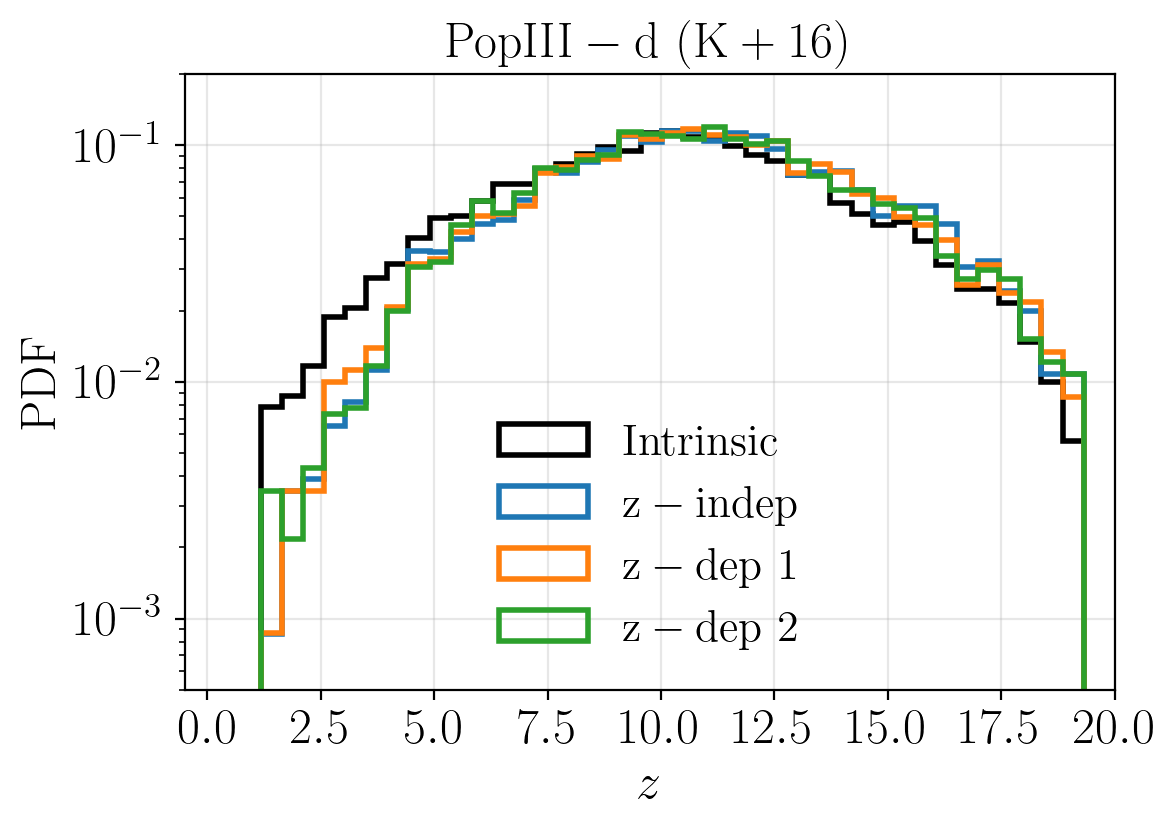

In [158]:
df  = pd.read_csv("SecondRun/PopIIId/popIII_SNRLb_final.csv", sep=",")
df1 = pd.read_csv("SecondRun/PopIIId/popIII_z_indep.csv", sep=",")
df2 = pd.read_csv("SecondRun/PopIIId/popIII_z_dep1.csv", sep=",")
df3 = pd.read_csv("SecondRun/PopIIId/popIII_z_dep2.csv", sep=",")

sigma_z = .55
for d in [df, df1, df2, df3]:
    d["z_merger_noisy"] = d["z_merger"] + np.random.normal(0, sigma_z, len(d))

z_bins = np.linspace(df1["z_merger"].min(), df1["z_merger"].max(), 40)

plt.figure(figsize=(6,4))

plt.hist(df["z_merger_noisy"], bins=z_bins, density=True, histtype='step', color='black', lw=2, label=r"$\mathrm{Intrinsic}$")
plt.hist(df1["z_merger_noisy"], bins=z_bins, density=True, histtype='step', color='tab:blue', lw=2, label=r"$\mathrm{z-indep}$")
plt.hist(df2["z_merger_noisy"], bins=z_bins, density=True, histtype='step', color='tab:orange', lw=2, label=r"$\mathrm{z-dep\ 1}$")
plt.hist(df3["z_merger_noisy"], bins=z_bins, density=True, histtype='step', color='tab:green', lw=2, label=r"$\mathrm{z-dep\ 2}$")

plt.yscale('log')
plt.xlim(-0.5, 20)
plt.ylim(5e-4, 2e-1)

plt.xticks(np.arange(0,21,2.5))
plt.xlabel(r"$z$", fontsize=18)
plt.tick_params(labelsize=18)
plt.ylabel(r"$\mathrm{PDF}$", fontsize=18)
plt.legend(frameon=False, fontsize=16)
plt.grid(alpha=0.3)
plt.title(r"$\mathrm{PopIII-d\ (K+16) }$", fontsize=18)
plt.savefig("SecondRun/Images/lensed_dist_popIII.pdf", dpi=300, bbox_inches="tight")
plt.show()

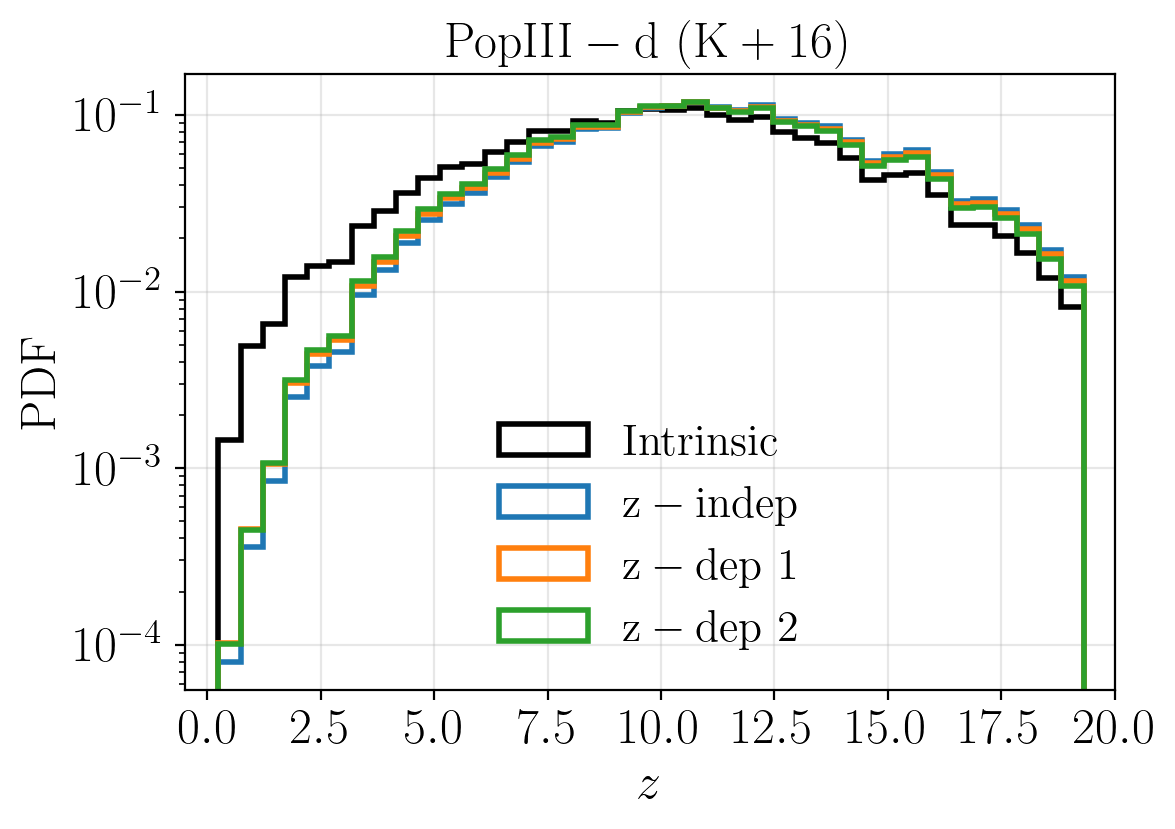

In [15]:
df  = pd.read_csv("SecondRun/PopIIId/popIII_SNRLb_final.csv", sep=",")
#df1 = pd.read_csv("SecondRun/PopIIId/popIII_z_indep.csv", sep=",")
#df2 = pd.read_csv("SecondRun/PopIIId/popIII_z_dep1.csv", sep=",")
#df3 = pd.read_csv("SecondRun/PopIIId/popIII_z_dep2.csv", sep=",")

sigma_z = .5
df["z_merger_noisy"] = df["z_merger"] + np.random.normal(0, sigma_z, len(df))

z_bins = np.linspace(df["z_merger"].min(), df["z_merger"].max(), 40)


z_hist, z_edges = np.histogram(df["z_merger_noisy"], bins=z_bins, weights=df["d2N_dzdt"])
z_hist_lensindep, z_edges_lens = np.histogram(df["z_merger_noisy"], bins=z_bins, weights=df["tau_indep"])
z_hist_lensdep1, z_edges_lens = np.histogram(df["z_merger_noisy"], bins=z_bins,  weights=df["tau_dep1"])
z_hist_lensdep2, z_edges_lens = np.histogram(df["z_merger_noisy"], bins=z_bins,  weights=df["tau_dep2"])



plt.figure(figsize=(6,4))

plt.hist(df["z_merger_noisy"], bins=z_bins, density=True, histtype='step', color='black', lw=2, label=r"$\mathrm{Intrinsic}$")
#plt.hist(0.5 * (z_edges[:-1] + z_edges[1:]), bins=z_bins, weights= z_hist, density=True, histtype='step', color='black', lw=2, label=r"$\mathrm{Intrinsic}$")

plt.hist(0.5 * (z_edges_lens[:-1] + z_edges_lens[1:]), bins=z_bins, weights= z_hist_lensindep, density=True, histtype='step', color='tab:blue', lw=2, label=r"$\mathrm{z-indep}$")
plt.hist(0.5 * (z_edges_lens[:-1] + z_edges_lens[1:]), bins=z_bins, weights= z_hist_lensdep1,density=True, histtype='step', color='tab:orange', lw=2, label=r"$\mathrm{z-dep\ 1}$")
plt.hist(0.5 * (z_edges_lens[:-1] + z_edges_lens[1:]), bins=z_bins, weights= z_hist_lensdep2, density=True, histtype='step', color='tab:green', lw=2, label=r"$\mathrm{z-dep\ 2}$")

plt.yscale('log')
plt.xlim(-0.5, 20)
#plt.ylim(5e-4, 2e-1)

plt.xticks(np.arange(0,21,2.5))
plt.xlabel(r"$z$", fontsize=18)
plt.tick_params(labelsize=18)
plt.ylabel(r"$\mathrm{PDF}$", fontsize=18)
plt.legend(frameon=False, fontsize=16)
plt.grid(alpha=0.3)
plt.title(r"$\mathrm{PopIII-d\ (K+16) }$", fontsize=18)
plt.savefig("SecondRun/Images/lensed_dist_popIII.pdf", dpi=300, bbox_inches="tight")
plt.show()

# Strong Lensing Rates

In [13]:
files_with_norm = [
    ("SecondRun/PopIIId/popIII_z_indep.csv", 725.689404934688),
    ("SecondRun/PopIIId/popIII_z_dep1.csv", 1144.1647597254005),
    ("SecondRun/PopIIId/popIII_z_dep2.csv", 878.7346221441124),
    ("SecondRun/Q3d/Q3d_z_indep.csv", 26315.78947368421),
    ("SecondRun/Q3d/Q3d_z_dep1.csv", 38461.53846153846),
    ("SecondRun/Q3d/Q3d_z_dep2.csv", 27777.777777777777),
    ("SecondRun/Q3nod/Q3nod_z_indep.csv", 1724.1379310344828),
    ("SecondRun/Q3nod/Q3nod_z_dep1.csv", 2702.7027027027025),
    ("SecondRun/Q3nod/Q3nod_z_dep2.csv", 2066.115702479339),
    ("SecondRun/HSnodnoSN/HSnodnoSN_z_indep.csv", 21.618817018332756),
    ("SecondRun/HSnodnoSN/HSnodnoSN_z_dep1.csv", 35.02626970227671),
    ("SecondRun/HSnodnoSN/HSnodnoSN_z_dep2.csv", 27.654867256637168),
    ("SecondRun/HSnodSN/HSnodSN_z_indep.csv", 23.194322029967065),
    ("SecondRun/HSnodSN/HSnodSN_z_dep1.csv", 37.55445395823945),
    ("SecondRun/HSnodSN/HSnodSN_z_dep2.csv", 29.633141705683638),
    ("SecondRun/HSnodSNhighaccr/HSnodSNhighaccr_z_indep.csv", 97.75171065493646),
    ("SecondRun/HSnodSNhighaccr/HSnodSNhighaccr_z_dep1.csv", 156.88735487919672),
    ("SecondRun/HSnodSNhighaccr/HSnodSNhighaccr_z_dep2.csv", 122.72950417280313)
]

results = []
n_runs = 100  

for file_path, norm in files_with_norm:   
    df = pd.read_csv(file_path)

    cond1_list, cond2_list, cond3_list = [], [], []

    for _ in range(n_runs):
        df["x"] = np.random.rand(len(df))
        df["y"] = df["x"]**0.5
        df["xp"] = df["y"] + 1
        df["xm"] = df["y"] - 1
        df["mup"] = 1 + (1 / df["y"]) 
        df["mum"] = 1 - (1 / df["y"]) 
        df["SNRp"] = df["Mean_SNR"] * np.sqrt(np.abs(df["mup"]))
        df["SNRm"] = df["Mean_SNR"] * np.sqrt(np.abs(df["mum"]))

        cond1 = (df['SNRm'] < 8) & (df['SNRp'] > 8)
        cond2 = (df['SNRm'] > 8) & (df['SNRp'] > 8) 
        cond3 = (df['Mean_SNR'] < 8) & (df['SNRp'] > 8)

        n_cond1 = df[cond1].shape[0] / norm
        n_cond2 = df[cond2].shape[0] / norm
        n_cond3 = df[cond3].shape[0] / norm

        cond1_list.append(n_cond1)
        cond2_list.append(n_cond2)
        cond3_list.append(n_cond3)

    res = {
        "File": file_path,
        "1Detected_mean": np.mean(cond1_list),
        "1Detected_std": np.std(cond1_list),
        "1Detected_min": np.min(cond1_list),
        "1Detected_max": np.max(cond1_list),
        "2Detected_mean": np.mean(cond2_list),
        "2Detected_std": np.std(cond2_list),
        "2Detected_min": np.min(cond2_list),
        "2Detected_max": np.max(cond2_list),
        "Boosted_mean": np.mean(cond3_list),
        "Boosted_std": np.std(cond3_list),
        "Boosted_min": np.min(cond3_list),
        "Boosted_max": np.max(cond3_list),
    }
    results.append(res)
    
    print(f"{file_path}")
    print(f"  1 Detected Mean: {res['1Detected_mean']:.3f}")
    print(f"  2 Detected Mean: {res['2Detected_mean']:.3f}")
    print(f"  Boosted Mean:    {res['Boosted_mean']:.3f}")
    
results_df = pd.DataFrame(results)
results_df.to_csv("SecondRun/SLrates_results_summary.csv", index=False)

SecondRun/PopIIId/popIII_z_indep.csv
  1 Detected Mean: 1.862
  2 Detected Mean: 0.946
  Boosted Mean:    1.704
SecondRun/PopIIId/popIII_z_dep1.csv
  1 Detected Mean: 1.164
  2 Detected Mean: 0.621
  Boosted Mean:    1.047
SecondRun/PopIIId/popIII_z_dep2.csv
  1 Detected Mean: 1.564
  2 Detected Mean: 0.805
  Boosted Mean:    1.425
SecondRun/Q3d/Q3d_z_indep.csv
  1 Detected Mean: 0.001
  2 Detected Mean: 0.189
  Boosted Mean:    0.000
SecondRun/Q3d/Q3d_z_dep1.csv
  1 Detected Mean: 0.001
  2 Detected Mean: 0.129
  Boosted Mean:    0.000
SecondRun/Q3d/Q3d_z_dep2.csv
  1 Detected Mean: 0.001
  2 Detected Mean: 0.178
  Boosted Mean:    0.000
SecondRun/Q3nod/Q3nod_z_indep.csv
  1 Detected Mean: 0.084
  2 Detected Mean: 2.809
  Boosted Mean:    0.013
SecondRun/Q3nod/Q3nod_z_dep1.csv
  1 Detected Mean: 0.052
  2 Detected Mean: 1.795
  Boosted Mean:    0.004
SecondRun/Q3nod/Q3nod_z_dep2.csv
  1 Detected Mean: 0.071
  2 Detected Mean: 2.345
  Boosted Mean:    0.008
SecondRun/HSnodnoSN/HSnodnoS

In [3]:
df = pd.read_csv("SecondRun/SLrates_results_summary.csv")

intrinsic_detec = [321, 321, 321, 73, 73, 73, 650, 650, 650, 37979, 37979, 37979, 35510, 35510, 35510, 9075, 9075, 9075]

lensed_detec= df["1Detected_mean"] + df["2Detected_mean"]

print(f'promedio:{np.mean(lensed_detec/intrinsic_detec *100)}')
lensed_detec/intrinsic_detec *100

promedio:0.4562054744256066


0     0.874764
1     0.555820
2     0.738119
3     0.259665
4     0.177452
5     0.245780
6     0.445055
7     0.284101
8     0.371562
9     0.607002
10    0.374081
11    0.474091
12    0.603020
13    0.372384
14    0.472652
15    0.560677
16    0.349123
17    0.446348
dtype: float64

In [45]:
intrinsic_lensed_events= [6.9,4.4,5.7,0.19,0.13,0.18,2.9,1.9,2.4,231,143,181,216,133,169,51,32,41]

print(lensed_detec/intrinsic_lensed_events *100)

0      40.695535
1      40.549627
2      41.567746
3      99.766200
4      99.646200
5      99.677400
6      99.753800
7      97.192574
8     100.631263
9      99.798021
10     99.351205
11     99.477958
12     99.135453
13     99.423747
14     99.312881
15     99.767574
16     99.009135
17     98.795295
dtype: float64


In [33]:

df = pd.read_csv("SecondRun/SLrates_results_summary.csv")

lensed_detec= df["1Detected_mean"] + df["2Detected_mean"]
boosted = df["Boosted_mean"] 

print(boosted/lensed_detec *100)

0     60.691554
1     58.655824
2     60.135252
3      0.126496
4      0.106577
5      0.117780
6      0.434871
7      0.199761
8      0.340282
9      1.080688
10     1.050186
11     0.911756
12     0.838793
13     0.804678
14     0.876429
15     0.799196
16     0.938509
17     0.951262
dtype: float64


In [54]:
lensed_detec

0       2.807992
1       1.784184
2       2.369362
3       0.189556
4       0.129540
5       0.179419
6       2.892860
7       1.846659
8       2.415150
9     230.533428
10    142.072223
11    180.055104
12    214.132579
13    132.233583
14    167.838768
15     50.881463
16     31.682923
17     40.506071
dtype: float64

In [63]:
a = [(2.807992,1.784184,2.369362),(0.189556,0.129540,0.179419),(2.892860,1.846659,2.415150),
     (230.533428,142.072223,180.055104),(214.132579,132.233583,167.838768),(50.881463,31.682923,40.506071) ]

results = []

for triplet in a:
    triplet = np.array(triplet)
    mean_val = np.mean(triplet)
    frac_diffs = np.abs(triplet - mean_val) / mean_val
    frac_range = (np.max(triplet) - np.min(triplet)) / mean_val
    
    results.append({
        "valores": triplet,
        "mean": mean_val,
        "frac_diffs": frac_diffs,
        "frac_range": frac_range
    })
    print(frac_range)



0.44119905687507555
0.3611686709527297
0.4386789940946256
0.48019261834504595
0.47781919943863616
0.4679889991795512


# Time Delays

In [66]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 32 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   m1                     10000 non-null  float64
 1   m2                     10000 non-null  float64
 2   a1                     10000 non-null  float64
 3   a2                     10000 non-null  float64
 4   Dl_s                   10000 non-null  float64
 5   z_merger               10000 non-null  float64
 6   alpha                  10000 non-null  float64
 7   beta                   10000 non-null  float64
 8   gamma                  10000 non-null  float64
 9   halo_density           10000 non-null  float64
 10  d2N_dzdt               10000 non-null  float64
 11  Dc_s                   10000 non-null  float64
 12  Da_s                   10000 non-null  float64
 13  Dc_l1                  10000 non-null  float64
 14  z_l1                   10000 non-null  float64
 15  Da_

In [2]:
h = cosmo.h
H0 = cosmo.H0.value
ckm = 3.0e5        
cmpc = 9.72e-15    

# --- Parámetros de la función ---
phi_star0 = 2.099e-2 * (h/0.7)**3   # Mpc^-3
sigma_star0 = 113.78                 # km/s
alpha, beta = 0.94, 1.85
nu_n, nu_v = -1.18, 0.18

# -- z-independent --
def phi_indep(sigma):    
    return (phi_star0 * (sigma/sigma_star0)**alpha * np.exp(-(sigma/sigma_star0)**beta) * beta/(gamma(alpha/beta)*sigma))

# -- z-dependent1 --
def phi_dep1(sigma, z): 
    return ((phi_star0*(1+z)**nu_n) * (sigma/(sigma_star0*(1+z)**nu_v))**alpha * np.exp(-(sigma/(sigma_star0*(1+z)**nu_v))**beta) * beta/(gamma(alpha/beta)*sigma))

# -- z-dependent2 --
def phi_dep2(sigma, z):
    a0, a1, a2   = 7.391498, 5.729400, -1.120552
    al0, al1, al2 = -6.863393, -5.273271, 1.104114
    be0, be1, be2 = 2.852083, 1.255696, -0.286638
    ga0, ga1, ga2 = 0.067032, -0.048683, 0.007648

    def phi_hyd(sigma, z):
        A_hyd     = a0  + a1*z  + a2*z**2
        alpha_hyd = al0 + al1*z + al2*z**2
        beta_hyd  = be0 + be1*z + be2*z**2
        gamma_hyd = ga0 + ga1*z + ga2*z**2
        sigma_star_hyd = 10**gamma_hyd

        x = np.log10(sigma / sigma_star_hyd)
        n = 10**(A_hyd + alpha_hyd*x + beta_hyd*x**2 - np.exp(x))
        phi1 = n/sigma * (alpha_hyd + 2*beta_hyd*x - np.exp(x))
        return phi1

    phi_z = phi_hyd(sigma, z)
    phi_0 = phi_hyd(sigma, 0.0)
    ratio = phi_z / phi_0

    return ratio * phi_indep(sigma)

def sample_sigma_from_phi(func, z=None, sigma_min=60, sigma_max=400, npts=2000, N=1):
    sigma = np.linspace(sigma_min, sigma_max, npts)
    vals = func(sigma) if z is None else func(sigma, z)
    vals = np.clip(vals, 0, None)  # valores negativos a 0
    vals = np.nan_to_num(vals, nan=0.0, neginf=0.0, posinf=0.0)
    pdf = vals / simpson(vals, x=sigma)
    cdf = np.cumsum(pdf)
    cdf /= cdf[-1]
    return np.interp(np.random.rand(N), cdf, sigma)

In [6]:
files = [
    ("SecondRun/PopIIId/popIII_SNRLb_final.csv", 7.092047686928647),
    ("SecondRun/Q3d/Q3d_SNRLb_final.csv", 136.01186023421243),
    ("SecondRun/Q3nod/Q3nod_SNRLb_final.csv", 15.215581973187101),
    ("SecondRun/HSnodnoSN/HSnodnoSN_SNRLb_final.csv", 0.25404047565928967),
    ("SecondRun/HSnodSN/HSnodSN_SNRLb_final.csv", 0.27181526086667807),
    ("SecondRun/HSnodSNhighaccr/HSnodSNhighaccr_SNRLb_final.csv", 1.0630494636915455)
]

for file, norm in files:
    df = pd.read_csv(file)

    # --- z indep ---
    df["y1"] = np.random.rand(len(df))**0.5
    df["sigma_z_indep"] = df["z_l1"].apply(lambda z: sample_sigma_from_phi(phi_indep, N=1)[0])
    df["deltat_z_indep"] = ((32*np.pi**2)/cmpc) * (df["sigma_z_indep"]/ckm)**4 * (df["Da_l1"]*df["Da_l1s"]/df["Da_s"]) * (1+df["z_l1"])
    df["timedelay_z_indep"] = df["y1"] * df["deltat_z_indep"]

    # --- z dep1 ---
    df["y2"] = np.random.rand(len(df))**0.5
    df["sigma_z_dep1"] = df["z_l1"].apply(lambda z: sample_sigma_from_phi(phi_dep1, z=z, N=1)[0])
    df["deltat_z_dep1"] = ((32*np.pi**2)/cmpc) * (df["sigma_z_dep1"]/ckm)**4 * (df["Da_l2"]*df["Da_l2s"]/df["Da_s"]) * (1+df["z_l2"])
    df["timedelay_z_dep1"] = df["y2"] * df["deltat_z_dep1"]

    # --- z dep2 ---
    df["y3"] = np.random.rand(len(df))**0.5
    df["sigma_z_dep2"] = df["z_l1"].apply(lambda z: sample_sigma_from_phi(phi_dep2, z=z, N=1)[0])
    df["deltat_z_dep2"] = ((32*np.pi**2)/cmpc) * (df["sigma_z_dep2"]/ckm)**4 * (df["Da_l3"]*df["Da_l3s"]/df["Da_s"]) * (1+df["z_l3"])
    df["timedelay_z_dep2"] = df["y3"] * df["deltat_z_dep2"]

    outname = file.replace(".csv", "_timedelays1.csv")
    df.to_csv(outname, index=False)

/tmp/ipykernel_4915/345958636.py:51: RuntimeWarning: invalid value encountered in divide
  pdf = vals / simpson(vals, x=sigma)
/tmp/ipykernel_4915/345958636.py:51: RuntimeWarning: invalid value encountered in divide
  pdf = vals / simpson(vals, x=sigma)
/tmp/ipykernel_4915/345958636.py:51: RuntimeWarning: invalid value encountered in divide
  pdf = vals / simpson(vals, x=sigma)


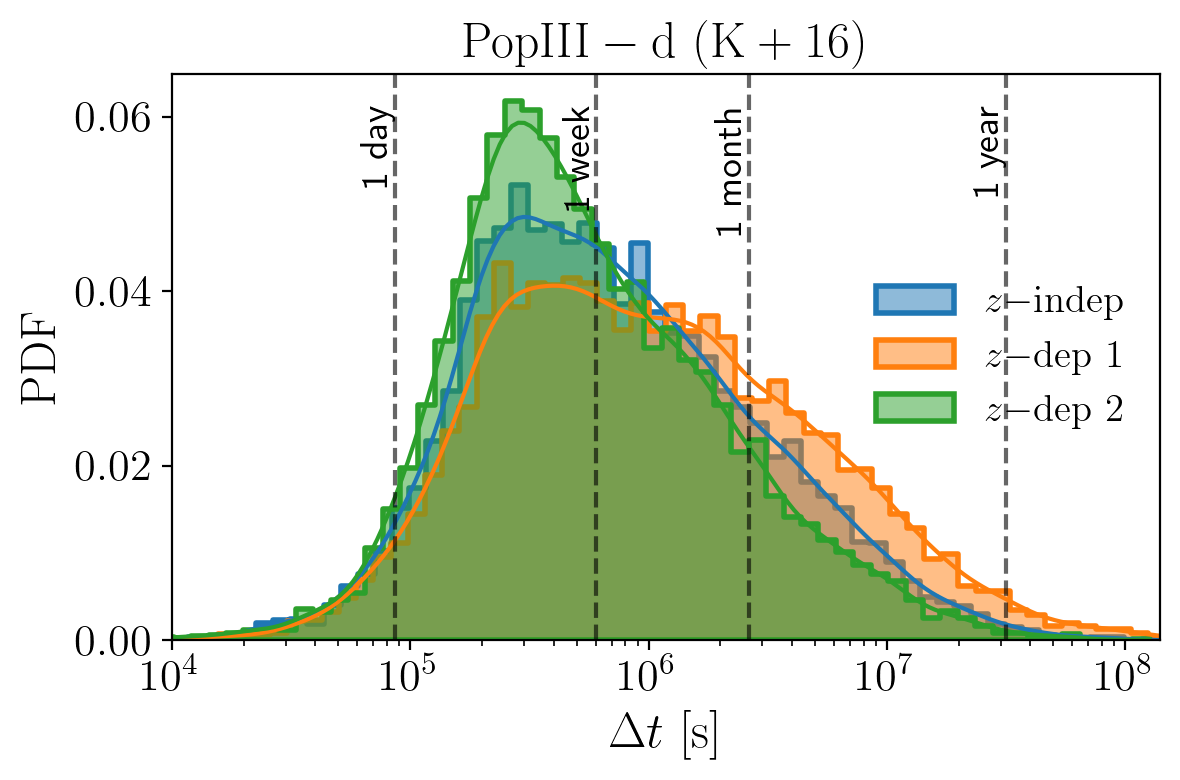

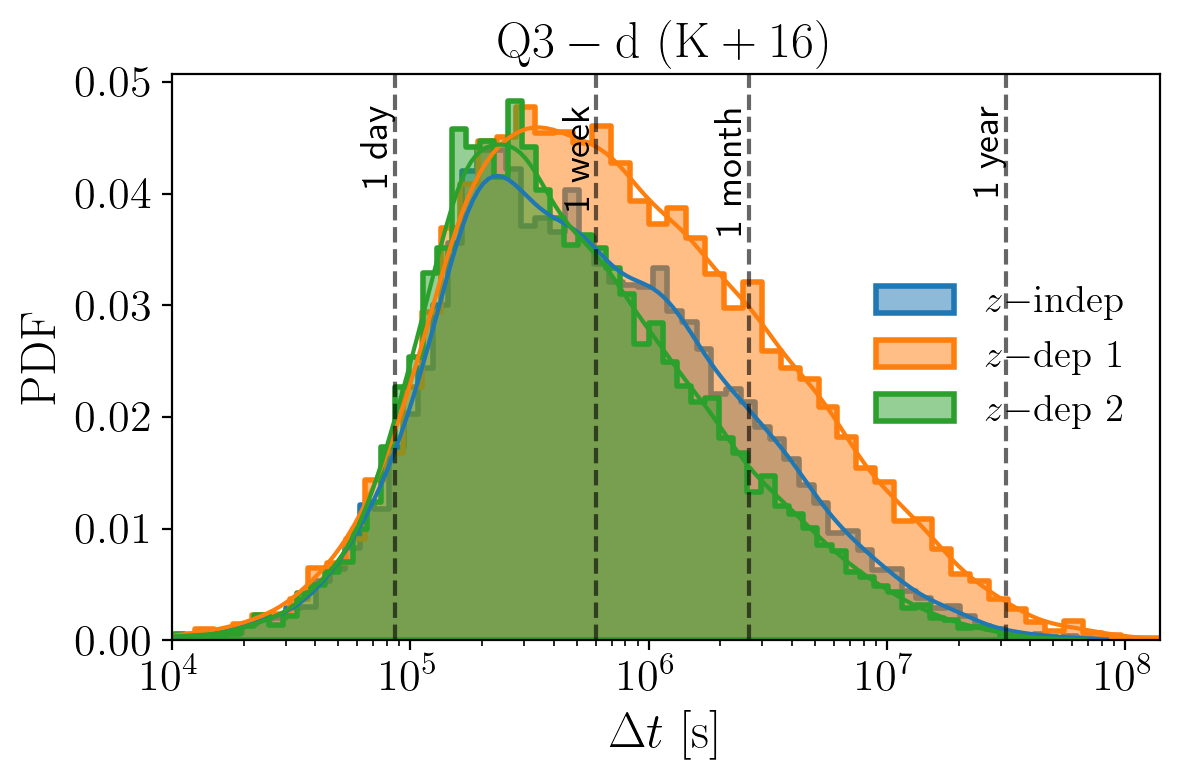

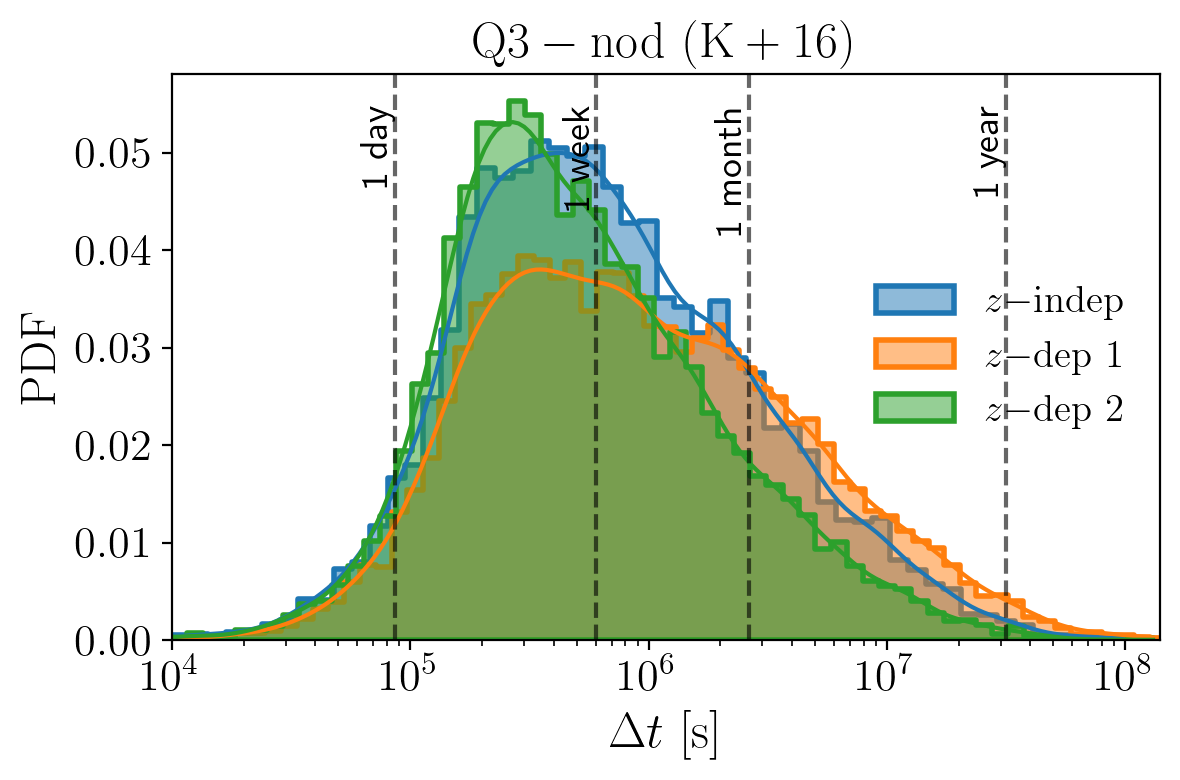

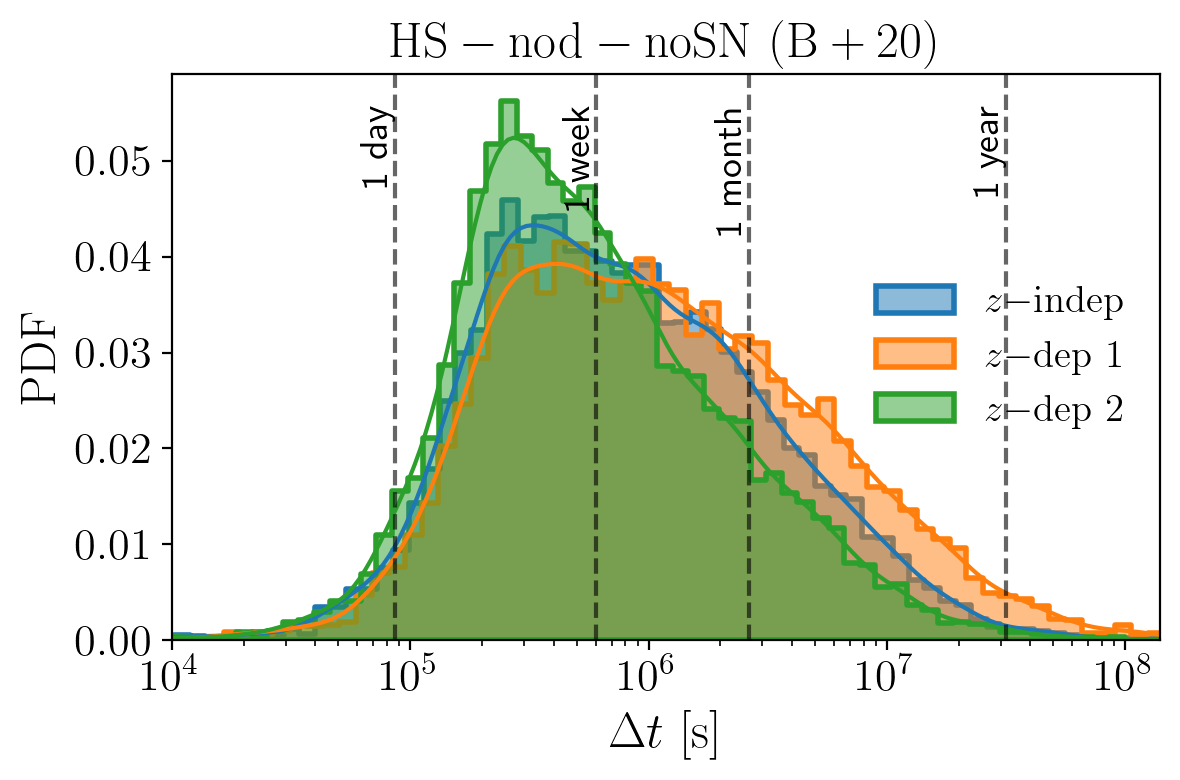

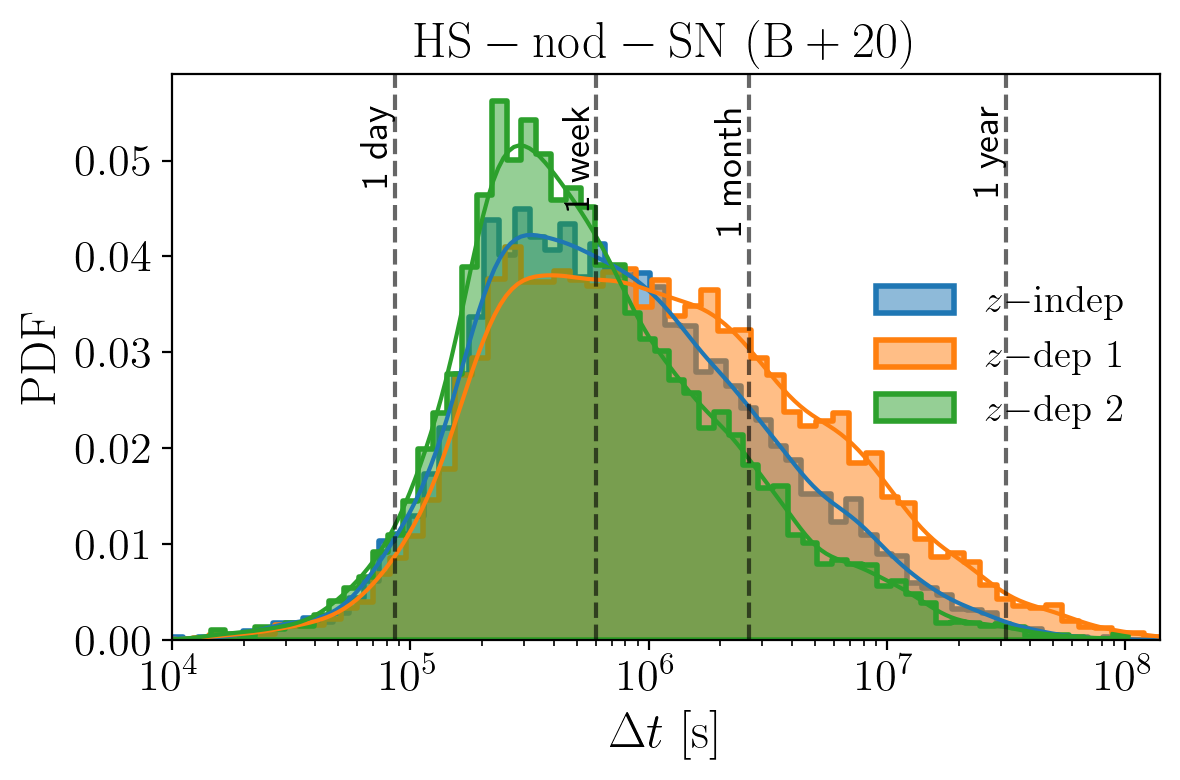

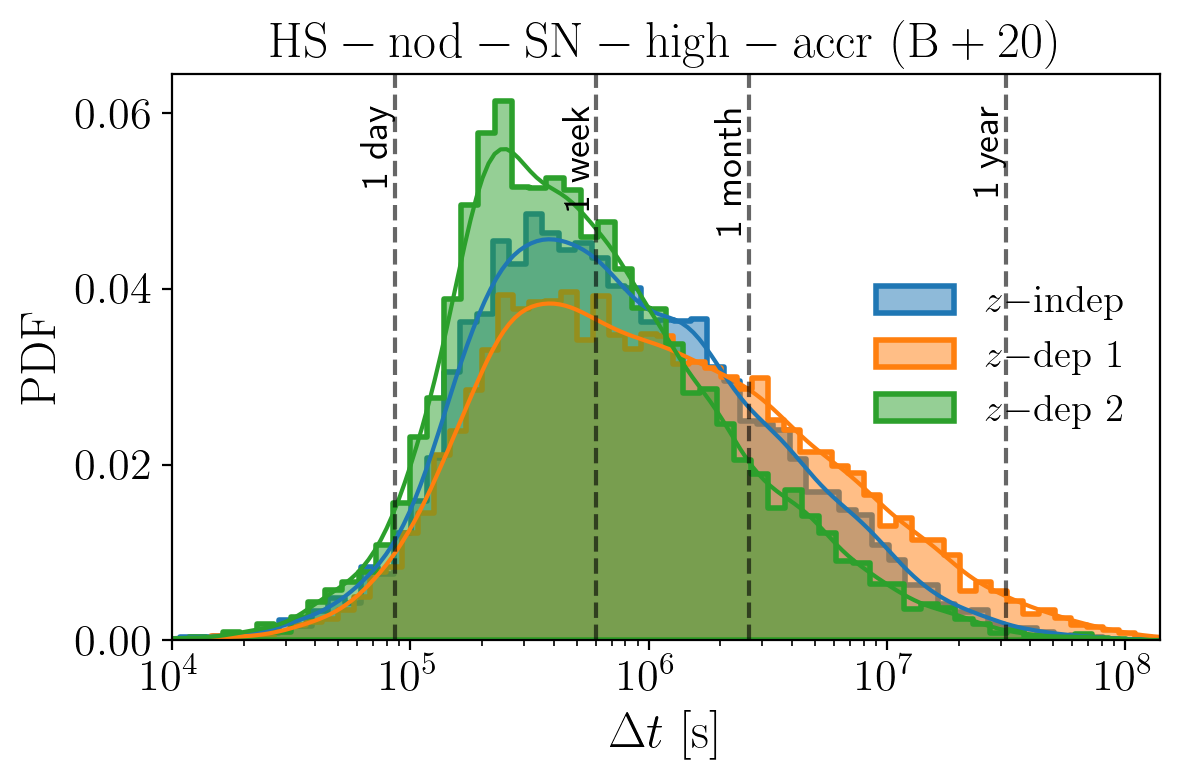

In [12]:
import seaborn as sns

files = [
    ("SecondRun/PopIIId/popIII_SNRLb_final_timedelays1.csv", "popIII",'PopIII-d\ (K+16)'),
    ("SecondRun/Q3d/Q3d_SNRLb_final_timedelays1.csv", "Q3d",'Q3-d\ (K+16)'),
    ("SecondRun/Q3nod/Q3nod_SNRLb_final_timedelays1.csv", "Q3nod",'Q3-nod\ (K+16)'),
    ("SecondRun/HSnodnoSN/HSnodnoSN_SNRLb_final_timedelays1.csv", "HSnodnoSN",'HS-nod-noSN\ (B+20)'),
    ("SecondRun/HSnodSN/HSnodSN_SNRLb_final_timedelays1.csv", "HSnodSN",'HS-nod-SN\ (B+20)'),
    ("SecondRun/HSnodSNhighaccr/HSnodSNhighaccr_SNRLb_final_timedelays1.csv", "HSnodSNhighaccr",'HS-nod-SN-high-accr\ (B+20)'),
]

seg_dia = 86400
seg_semana = 7 * seg_dia
seg_mes = 30.44 * seg_dia
seg_ano = 365.25 * seg_dia

for file, label_base, title in files:
    df = pd.read_csv(file)

    timedelay_z_indep = df["timedelay_z_indep"].values
    timedelay_z_dep1  = df["timedelay_z_dep1"].values
    timedelay_z_dep2  = df["timedelay_z_dep2"].values

    plt.figure(figsize=(6, 4))
    plt.xscale("log")

    sns.histplot(
        timedelay_z_indep,
        bins=70,
        stat='probability',
        kde=True,
        element='step',
        label=r"$z\mathrm{-indep}$",
        color="tab:blue",
        linewidth=2
    )
    sns.histplot(
        timedelay_z_dep1,
        bins=70,
        stat='probability',
        kde=True,
        element='step',
        label=r"$z\mathrm{-dep\ 1}$",
        color="tab:orange",
        linewidth=2
    )
    sns.histplot(
        timedelay_z_dep2,
        bins=70,
        stat='probability',
        kde=True,
        element='step',
        label=r"$z\mathrm{-dep\ 2}$",
        color="tab:green",
        linewidth=2
    )

    for val, ref_label in zip([seg_dia, seg_semana, seg_mes, seg_ano],
                              ["1 day", "1 week", "1 month", "1 year"]):
        plt.axvline(val, color="k", linestyle="--", alpha=0.6)
        plt.text(val, plt.ylim()[1]*0.95, ref_label, color="k", rotation=90,
                 ha='right', va='top', fontsize=14)

    plt.xlabel(r"$\Delta t \ \mathrm{[s]}$", fontsize=18)
    plt.ylabel(r"$\mathrm{PDF}$", fontsize=18)
    plt.xlim(1e4, 1.4e8)
    plt.legend(frameon=False, fontsize=14)
    plt.title(rf'$\mathrm{{{title}}}$', fontsize=18)
    plt.tick_params(labelsize=16)
    plt.tight_layout()

    plt.savefig(f"SecondRun/Images/timedelays_{label_base}_sigma60.pdf", dpi=300)
    plt.show()


# Reproduccion Fig 1 Oguri2018, Fig 7 Torrey2015

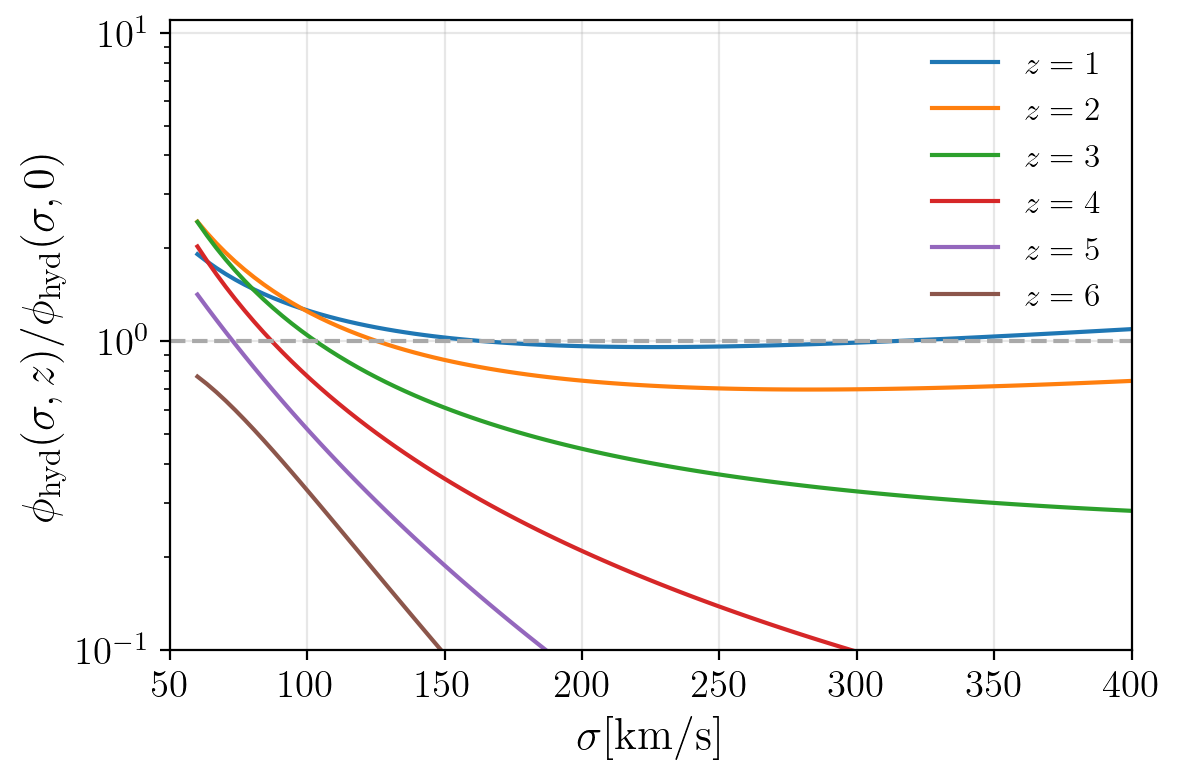

In [10]:
z_vals = np.array([ 0,1, 2, 3, 4, 5, 6])
sigma = np.linspace(60, 400, 100)

a0, a1, a2     = 7.391498     ,  5.729400     , -1.120552
al0, al1, al2  = -6.86339338  , -5.27327109   , 1.10411386
be0, be1, be2  = 2.85208259   , 1.25569600    , -0.28663846
ga0, ga1, ga2  = 0.06703215   , -0.04868317   , 0.00764841

def phi_hyd(z, sigma):
    A_hyd          = a0  + a1*z  + a2*z**2
    alpha_hyd      = al0 + al1*z + al2*z**2
    beta_hyd       = be0 + be1*z + be2*z**2
    gamma_hyd      = ga0 + ga1*z + ga2*z**2
    sigma_star_hyd = 10**gamma_hyd

    x = np.log10(sigma / sigma_star_hyd)
    
    n = 10**(A_hyd + alpha_hyd*x + beta_hyd*x**2 - np.exp(x))
    phi1 = n/sigma * (alpha_hyd + 2*beta_hyd*x - np.exp(x))
    return phi1

phi_hyd = {z: phi_hyd(z, sigma) for z in z_vals}

phi_hyd0 = phi_hyd[0]
N = {z: phi_hyd[z] / phi_hyd0 for z in z_vals}


plt.figure(figsize=(6,4))

for z in [1,2,3,4,5,6]:
    plt.plot(sigma, N[z], label=f"$z={z}$", linewidth=1.5 )
plt.axhline(1.0, ls="--", c="darkgrey", lw=1.5)
plt.xlabel(r"$\sigma \mathrm{ [km/s]}$", fontsize= 16)
plt.ylabel(r"$\phi_{\rm hyd}(\sigma, z)/\phi_{\rm hyd}(\sigma, 0)$", fontsize= 16)
plt.legend(fontsize= 12, frameon=False, loc='upper right')
plt.xlim(50, 400)
plt.ylim(0.1, 11)
plt.yscale('log')
plt.grid(True ,alpha=0.3)
plt.tick_params(labelsize = 14)
plt.tight_layout()

#plt.savefig("SecondRun/Images/VDF_hydro_python.pdf", dpi=300)
plt.show()

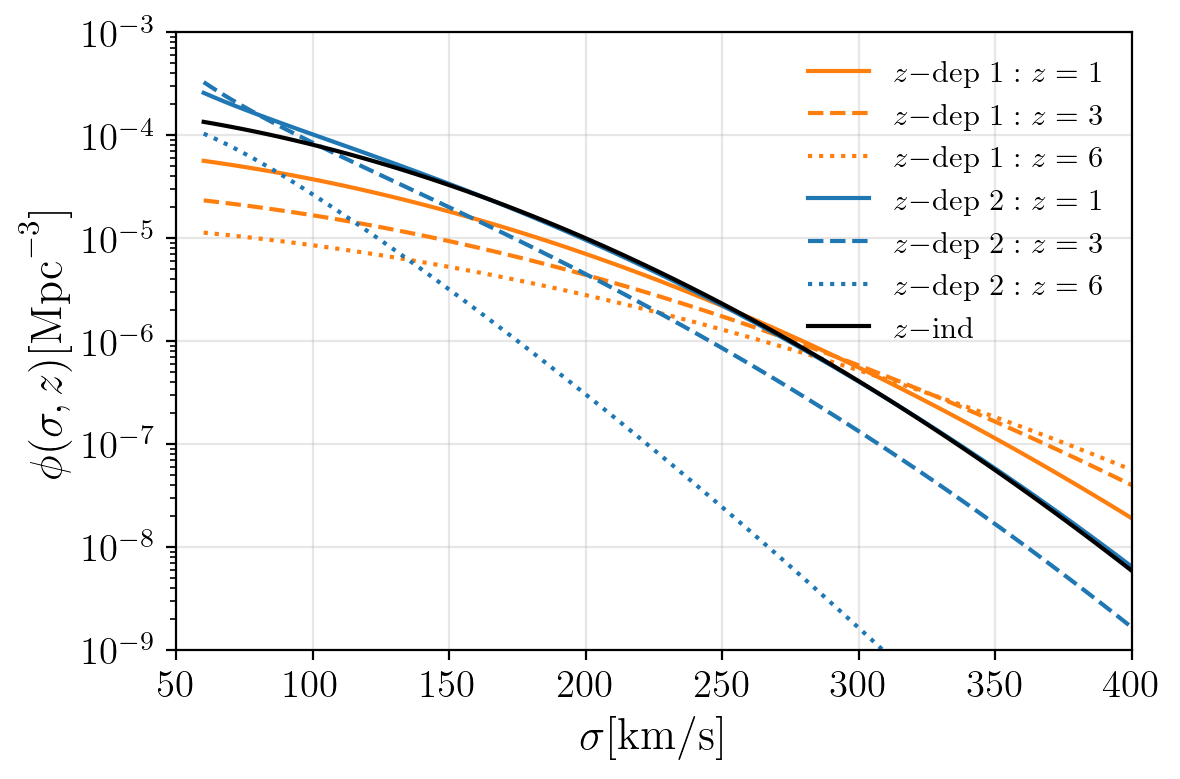

In [11]:
z_vals = np.array([1,3,6])
lines= ('-','--',':')

h = cosmo.h
H0 = cosmo.H0.value 
sigma = np.linspace(60, 400, 100)

phi_star0 = 2.099e-2 * (h/0.7)**3   # Mpc^-3
sigma_star0 = 113.78                 # km/s
alpha, beta = 0.94, 1.85
nu_n, nu_v = -1.18,0.18               
c_km_s = 3.0e5                      # km/s

# -- z-independent --
def phi_indep(sigma):    
    phi_indep = phi_star0*(sigma/sigma_star0)**alpha*np.exp(-(sigma/sigma_star0)**beta)*beta/(gamma(alpha/beta)*sigma)
    return phi_indep

# -- z-dependent1 --
def phi_dep1(sigma, z): 
    phi_dep1 = (phi_star0*(1+z)**nu_n)*(sigma/(sigma_star0*(1+z)**nu_v))**alpha*np.exp(-(sigma/(sigma_star0*(1+z)**nu_v))**beta)*beta/(gamma(alpha/beta)*sigma)
    return phi_dep1
    
# -- z-dependent2 --
def phi_dep2(sigma, z):
    a0, a1, a2   = 7.391498, 5.729400, -1.120552
    al0, al1, al2 = -6.863393, -5.273271, 1.104114
    be0, be1, be2 = 2.852083, 1.255696, -0.286638
    ga0, ga1, ga2 = 0.067032, -0.048683, 0.007648

    def phi_hyd(sigma, z):
        A_hyd     = a0  + a1*z  + a2*z**2
        alpha_hyd = al0 + al1*z + al2*z**2
        beta_hyd  = be0 + be1*z + be2*z**2
        gamma_hyd = ga0 + ga1*z + ga2*z**2
        sigma_star_hyd = 10**gamma_hyd

        x = np.log10(sigma / sigma_star_hyd)
        n = 10**(A_hyd + alpha_hyd*x + beta_hyd*x**2 - np.exp(x))

        phi1 = n/sigma * (alpha_hyd + 2*beta_hyd*x - np.exp(x))
        return phi1

    phi_z = phi_hyd(sigma, z)
    phi_0 = phi_hyd(sigma, 0.0)
    ratio = phi_z / phi_0

    return ratio * phi_indep(sigma)



plt.figure(figsize=(6,4))

for i,j in zip(z_vals, lines):
    plt.plot(sigma, phi_dep1(sigma, i), label = fr"$z\mathrm{{-dep\ 1:}}\ z={i}$", c = 'tab:orange', linestyle=j)
    
for i,j in zip(z_vals, lines):
    plt.plot(sigma, phi_dep2(sigma, i), label = fr"$z\mathrm{{-dep\ 2:}}\ z={i}$", c = 'tab:blue', linestyle=j)
    
plt.plot(sigma, phi_indep(sigma), label= r'$z\mathrm{-ind}$', c= 'k')    

plt.xlabel(r"$\sigma \mathrm{ [km/s]}$", fontsize= 16)
plt.ylabel(r"$\phi(\sigma, z)\mathrm{ [Mpc}^{-3}]$", fontsize= 16)
plt.xlim(50, 400)
plt.ylim(1e-9,1e-3)
plt.yscale('log')
plt.grid(True ,alpha=0.3)
plt.legend(fontsize= 11, frameon=False, loc='upper right')
plt.tick_params(labelsize = 14)
plt.tight_layout()
#plt.savefig("SecondRun/Images/VDF_comparison_python.pdf", dpi=300)
plt.show()